In [1]:
import sys
sys.path.append('/scratch/s2110831/JUPYTER/GRADIOMETRY_Synthetic/Codebase_iii_2021/Functions')
sys.path.append('/scratch/s2110831/JUPYTER/GRADIOMETRY_Synthetic/Codebase_iv_2022/Functions_2022')
sys.path.append('/exports/csce/datastore/geos/users/s2110831/out')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
import xarray as xr
import pandas as pd
import json
from pyasdf import ASDFDataSet
import h5py
import cmcrameri as cmm

In [4]:
# Import own functions
from vel_rho_Q_models import *
from FCT_plotting import *
from FCT_BP_filter_loop import BP_filter
from FCT_3D_gradients import dttv, _1st_DER, _2nd_DER, ROT_2nd_DER
from FCT_laplacian import *
from FCT_WaveEquations import *
from FCT_Normal_Solution import *
from FCT_objective import *
from FCT_LinearRegression import *
from FCT_MISFIT_WaveEquations import *

--> Server: 'https://l.mondaic.com/licensing_server', User: 'marthe.faber', Group: 'UniversityOfEdinburgh'.
--> Negotiating 1 license instance(s) for 'SalvusMesh' [license version 1.0.0] for 1 seconds ...
--> Success! [Total duration: 0.41 seconds]


In [5]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns

#Colorbar Tests

def plot_examples(cms):
    """
    helper function to plot two colormaps
    """
    np.random.seed(19680801)
    data = np.random.randn(30, 30)

    fig, axs = plt.subplots(1, 2, figsize=(6, 3), constrained_layout=True)
    for [ax, cmap] in zip(axs, cms):
        psm = ax.pcolormesh(data, cmap=cmap, rasterized=True, vmin=-4, vmax=4)
        fig.colorbar(psm, ax=ax)
    plt.show()

colors = ['ivory',"wheat",'burlywood','tab:brown']
cmap1 = LinearSegmentedColormap.from_list("mycmap", colors)

nodes = [0.0,0.3,0.8,1] #0.8
cmap2 = LinearSegmentedColormap.from_list("mycmap", list(zip(nodes, colors)))

#plot_examples([cmap1, cmap2])


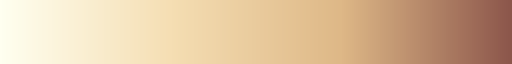

In [6]:
cmap1

In [7]:
colors = ["ivory", "wheat",'burlywood', 'tab:brown','black']
nodes = [0.0, 0.15, 0.33,0.65,1.0] #0.8
cmap3 = LinearSegmentedColormap.from_list("mycmap", list(zip(nodes, colors)))

In [8]:
palette = sns.color_palette("YlGnBu", 10).as_hex()
print(palette)
ccc=['#f2fabc', '#dcf1b2', '#bbe4b5', '#85cfba', '#57bec1', '#34a9c3', '#1d8dbe', '#2166ac', '#24479d']
YlGnBu=LinearSegmentedColormap.from_list("mycmap", ccc)

['#f2fabc', '#dcf1b2', '#bbe4b5', '#85cfba', '#57bec1', '#34a9c3', '#1d8dbe', '#2166ac', '#24479d', '#1d2e83']


In [9]:
colors = ['white','whitesmoke','lightyellow','#f2fabc', '#dcf1b2', '#bbe4b5', '#85cfba', '#57bec1', '#34a9c3', '#1d8dbe', '#2166ac', '#24479d', '#1d2e83','midnightblue']
nodes = [0.0,0.05,0.15,0.2,0.25,0.32,0.38,0.42, 0.46,0.5,0.57,0.7,0.8,1.0] #0.8
cmap4 = LinearSegmentedColormap.from_list("mycmap", list(zip(nodes, colors)))

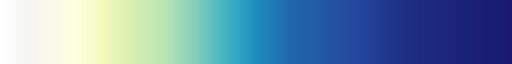

In [10]:
cmap4

In [11]:
my_cmap = cmap1

In [12]:
import matplotlib as mpl
mpl.rc('image', cmap=my_cmap)

## Project 

In [13]:
output = '/exports/csce/datastore/geos/users/s2110831/'

medium = 'acoustic' # 'acoustic' or 'elastic' or 'compare'

# Load an existing project.

if medium=='acoustic':
    project_name ='3DACOUSTIC_HET600x300_HET_abs2_4el_test2_hetZ_AMBIENTii_LARGER-8el'
    event_name = "src_loc_c_isotropic_FS_src_SURF"
    
    project_name2 ='3DACOUSTIC_HET600x300_HET_abs2_4el_test2_hetZ_AMBIENTii_LARGER-8elHOM_mean2' #_viz
    event_name2 = "src_loc_c_isotropic_FS_src_SURF"
else:
    project_name ='3DELASTIC_HET600x300_HET_abs2_4el_test2_hetZ_AMBIENTii_LARGER-'
    #project_name ='3DELASTIC_HET600x300_HET_abs2_4el_test2_hetZ_AMBIENTii_LARGER-ISOTROPIC_QUADRANT_noBOX'
    event_name = "src_loc_c_isotropic_FS_src_SURF"
    project_name2 = '3Delastic_homogeneous_1600_nt' #'3DELASTIC_HET600x300_HET_abs2_4el_test2_hetZ_AMBIENTii_LARGER-HOM'#'3Delastic_homogeneous_1600' #'3DELASTIC_HET600x300_HET_abs2_4el_test2_hetZ_AMBIENTii_LARGER-HOM'
    #project_name2 ='3DELASTIC_HET600x300_HET_abs2_4el_test2_hetZ_AMBIENTii_LARGER-ISOTROPIC_LAME_CONSTANT'
    event_name2 = "src_loc_c_isotropic_FS_src_SURF"
    
if medium=='compare':
    project_name ='3DACOUSTIC_HET600x300_HET_abs2_4el_test2_hetZ_AMBIENTii_LARGER-8el'
    event_name = "src_loc_c_isotropic_FS_src_SURF"
    project_name2 ='3DELASTIC_HET600x300_HET_abs2_4el_test2_hetZ_AMBIENTii_LARGER-'
    event_name2 = "src_loc_c_isotropic_FS_src_SURF"


In [14]:
# Read data from file:
path_ev = str(output)+"out/"+str(project_name)+"/EVENTS/"+str(event_name)
fig_ = str(path_ev)+'/FIGURES'
para_ = str(path_ev)+'/PARAMETERS'
input_ = str(path_ev)+'/INPUT_MODELS'
output_ = str(path_ev)+'/OUTPUT_FIELDS'
data_ = str(output_)+'/DATA'
#os.mkdir(data_)

mod_ = str(fig_)+'/MODELS'
fields = fig_+str('/FIELDS')
vel_ = fields+ str('/vel')
disp_ = fields+ str('/disp')

_res =  str(fig_)+'/RESULTS'

path_ev2 = str(output)+"out/"+str(project_name2)+"/EVENTS/"+str(event_name)
fig_2 = str(path_ev2)+'/FIGURES'
para_2 = str(path_ev2)+'/PARAMETERS'
input_2 = str(path_ev2)+'/INPUT_MODELS'
output_2 = str(path_ev2)+'/OUTPUT_FIELDS'
data_2 = str(output_2)+'/DATA'
mod_2 = str(fig_2)+'/MODELS'
fields2 = fig_2+str('/FIELDS')
vel_2 = fields2+ str('/vel')
disp_2 = fields2+ str('/disp')
_res2 =  str(fig_2)+'/RESULTS'

In [15]:
#OUT =  xr.open_dataset(output_+"/tmp.nc_compress/output.nc")
OUT =  xr.open_dataset(output_+"/output.nc")
OUT2 =  xr.open_dataset(output_2+"/output.nc")

In [16]:
# Simulation Parameters
PARA = json.load( open( para_+"/_ALL.json" ) )

# Models
ds_without_q = xr.open_dataset(str(input_)+"/ds_without_q.nc")
el_pos = xr.open_dataset(str(input_)+"/el_pos.nc")

model_true = xr.open_dataset(str(input_)+"/model_true.nc")

PARA2 = json.load( open( para_2+"/_ALL.json" ) )
el_pos2 = xr.open_dataset(str(input_2)+"/el_pos.nc")
model_true2 = xr.open_dataset(str(input_2)+"/model_true.nc")
ds_without_q2 = xr.open_dataset(str(input_2)+"/ds_without_q.nc")


In [17]:
nx  = PARA['x_domain']
ny  = PARA['y_domain']
nz  = PARA['z_domain']
rx0 = PARA['rec_grid_pos'][0]
ry0 = PARA['rec_grid_pos'][1]
rx1 = PARA['rec_grid_pos'][2]
ry1 = PARA['rec_grid_pos'][3]
sx  = PARA['src_loc'][0]
sy  = PARA['src_loc'][1]
sz  = abs(PARA['src_loc'][2]-nz)

In [18]:
# Receiver names & positions
receiver_field = xr.open_dataset(str(input_)+"/recs.nc")
#rec_list = pd.DataFrame(np.array(receiver_field.location), receiver_field.st_name)
rec_list = pd.DataFrame(np.array(receiver_field.location))

pd.set_option("display.max_rows", None, "display.max_columns", None)
#plt.scatter(rec_list[0], rec_list[1])
grid = np.array([rec_list[0], rec_list[1]])

rec_list


,0,1,2
0,261.0,261.0,300.0
1,261.0,261.0,299.0
2,261.0,261.0,298.0
3,261.0,263.0,300.0
4,261.0,263.0,299.0
5,261.0,263.0,298.0
6,261.0,265.0,300.0
7,261.0,265.0,299.0
8,261.0,265.0,298.0
9,261.0,267.0,300.0


In [19]:
PARA2

{'vel_model': 'heterogeneous_xy_hetZ',
 'rho_model': 'het_z',
 'Q_model': 'homogeneous+',
 'x_domain': 600,
 'y_domain': 600,
 'z_domain': 300,
 'h_max': 9.32180437578956,
 'source_type': 'ambient_noise1',
 'elements_per_wavelength': 4,
 'simulation_time': 3.0,
 'start_time': -0.22153191165941122,
 'dist_X': 2.0,
 'dist_Y': 2.0,
 'dist_Z': 1.0,
 'nt': 23544,
 'dt': 0.00013683608340735724,
 'dt_at': 0.00013683608340735724,
 'recs_surf': 1600,
 'recs_depth': 3,
 'recs_total': 1603,
 'rec_grid_pos': [261.0, 261.0, 339.0, 339.0, 300, 298],
 'src_loc': [300.0, 300.0, 290],
 'src_cent_f': 7.642857142857143}

In [20]:
PARA['dist_X']=2.0
PARA

{'vel_model': 'heterogeneous_xy_hetZ',
 'rho_model': 'sin_dist2b_hetZ',
 'Q_model': 'homogeneous+',
 'x_domain': 600,
 'y_domain': 600,
 'z_domain': 300,
 'h_max': 9.32180437578956,
 'source_type': 'ambient_noise1',
 'elements_per_wavelength': 4,
 'simulation_time': 3.0,
 'start_time': -0.2215319116594116,
 'dist_X': 2.0,
 'dist_Y': 2.0,
 'dist_Z': 1.0,
 'nt': 23544,
 'dt': 0.00013683608340735724,
 'dt_at': 0.00013683608340735724,
 'recs_surf': 1600,
 'recs_depth': 3,
 'recs_total': 1603,
 'rec_grid_pos': [261.0, 261.0, 339.0, 339.0, 300, 298],
 'src_loc': [300.0, 300.0, 290],
 'src_cent_f': 7.642857142857143}

In [21]:
nr = int(np.sqrt(PARA['recs_surf']))
nrz = PARA['recs_depth']
dist_r = PARA['dist_X']

nrx = nr
nry = nr
nrz = nrz

if medium=='acoustic':
    VEL_Z     = np.reshape(OUT.Pressure.data, (nrx,nry,nrz,PARA['nt']))
    VEL_Z_COPY     = np.reshape(OUT.Pressure.data, (nrx,nry,nrz,PARA['nt']))

    VEL_Z2     = np.reshape(OUT2.Pressure.data, (nrx,nry,nrz,PARA2['nt']))
    VEL_Z2_COPY     = np.reshape(OUT2.Pressure.data, (nrx,nry,nrz,PARA2['nt']))

elif medium=='elastic':
    #Potential spatial sampling
    dx = PARA['dist_X']
    dy = PARA['dist_Y']
    dz = PARA['dist_Z']

    Rx = (np.linspace(PARA['rec_grid_pos'][0], PARA['rec_grid_pos'][2], nr).astype(int) ).tolist()
    Ry = (np.linspace(PARA['rec_grid_pos'][1], PARA['rec_grid_pos'][3], nr).astype(int) ).tolist()
    Rz = (np.linspace(PARA['rec_grid_pos'][4], PARA['rec_grid_pos'][5], nrz).astype(int) -1 ).tolist()

    vp_sub     = model_true.VP[:,:,Rz].values #ds_without_q.vp.values[:,:,Rz]
    vp_sub     = vp_sub[Rx,:,:]
    vp_sub     = np.asarray(vp_sub[:,Ry,:])

    vs_sub     = model_true.VS[:,:,Rz].values #ds_without_q.vp.values[:,:,Rz]
    vs_sub     = vs_sub[Rx,:,:]
    vs_sub     = np.asarray(vs_sub[:,Ry,:])

    rho_grad   = model_true.RHO[:,:,Rz].values#ds_without_q.rho.values[:,:,Rz]#model_true.RHO[:,:,Rz].values #ds_without_q.rho.values[:,:,Rz]
    rho_grad   = rho_grad[Rx,:,:]
    rho_grad   = np.asarray(rho_grad[:,Ry,:])

    lame1 = ((vp_sub**2) * rho_grad) - (2 * (vs_sub**2) * rho_grad)
    lame2 = ( (vs_sub**2) * rho_grad)
    
    V_X_gradX=np.reshape(OUT.displacement_gradXx.data, (nrx,nry,nrz,PARA['nt']))
    V_Y_gradY=np.reshape(OUT.displacement_gradYy.data, (nrx,nry,nrz,PARA['nt']))
    V_Z_gradZ=np.reshape(OUT.displacement_gradZz.data, (nrx,nry,nrz,PARA['nt']))
    F_2D =(vp_sub[:,:,:,np.newaxis]**2 *  rho_grad[:,:,:,np.newaxis]) * (V_X_gradX + V_Y_gradY)
    

    #VEL_Z     = np.reshape(OUT.displacement_z.data, (nrx,nry,nrz,PARA['nt']))
    #VEL_Z_COPY     = np.reshape(OUT.displacement_z.data, (nrx,nry,nrz,PARA['nt']))
    VEL_Z     = np.reshape(F_2D, (nrx,nry,nrz,PARA['nt']))
    VEL_Z_COPY     = np.reshape(F_2D, (nrx,nry,nrz,PARA['nt']))
    
    dx = PARA2['dist_X']
    dy = PARA2['dist_Y']
    dz = PARA2['dist_Z']

    Rx = (np.linspace(PARA2['rec_grid_pos'][0], PARA2['rec_grid_pos'][2], nr).astype(int) ).tolist()
    Ry = (np.linspace(PARA2['rec_grid_pos'][1], PARA2['rec_grid_pos'][3], nr).astype(int) ).tolist()
    Rz = (np.linspace(PARA2['rec_grid_pos'][4], PARA2['rec_grid_pos'][5], nrz).astype(int) -1 ).tolist()

    vp_sub     = model_true2.VP[:,:,Rz].values #ds_without_q.vp.values[:,:,Rz]
    vp_sub     = vp_sub[Rx,:,:]
    vp_sub     = np.asarray(vp_sub[:,Ry,:])

    vs_sub     = model_true2.VS[:,:,Rz].values #ds_without_q.vp.values[:,:,Rz]
    vs_sub     = vs_sub[Rx,:,:]
    vs_sub     = np.asarray(vs_sub[:,Ry,:])

    rho_grad   = model_true2.RHO[:,:,Rz].values#ds_without_q.rho.values[:,:,Rz]#model_true.RHO[:,:,Rz].values #ds_without_q.rho.values[:,:,Rz]
    rho_grad   = rho_grad[Rx,:,:]
    rho_grad   = np.asarray(rho_grad[:,Ry,:])

    lame1 = ((vp_sub**2) * rho_grad) - (2 * (vs_sub**2) * rho_grad)
    lame2 = ( (vs_sub**2) * rho_grad)

    V_X_gradX=np.reshape(OUT2.displacement_gradXx.data, (nrx,nry,nrz,PARA2['nt']))
    V_Y_gradY=np.reshape(OUT2.displacement_gradYy.data, (nrx,nry,nrz,PARA2['nt']))
    V_Z_gradZ=np.reshape(OUT2.displacement_gradZz.data, (nrx,nry,nrz,PARA2['nt']))
    F_2D =(vp_sub[:,:,:,np.newaxis]**2 *  rho_grad[:,:,:,np.newaxis]) * (V_X_gradX + V_Y_gradY)

    #VEL_Z2     = np.reshape(OUT2.displacement_z.data, (nrx,nry,nrz,PARA2['nt']))
    #VEL_Z2_COPY     = np.reshape(OUT2.displacement_z.data, (nrx,nry,nrz,PARA2['nt']))
    VEL_Z2     = np.reshape(F_2D, (nrx,nry,nrz,PARA2['nt']))
    VEL_Z2_COPY     = np.reshape(F_2D, (nrx,nry,nrz,PARA2['nt']))
    
else:
    
    VEL_Z     = np.reshape(OUT.Pressure.data, (nrx,nry,nrz,PARA['nt']))
    VEL_Z_COPY     = np.reshape(OUT.Pressure.data, (nrx,nry,nrz,PARA['nt']))

    VEL_Z2     = np.reshape(OUT2.displacement_z.data, (nrx,nry,nrz,PARA2['nt']))
    VEL_Z2_COPY     = np.reshape(OUT2.displacement_z.data, (nrx,nry,nrz,PARA2['nt']))

No handles with labels found to put in legend.


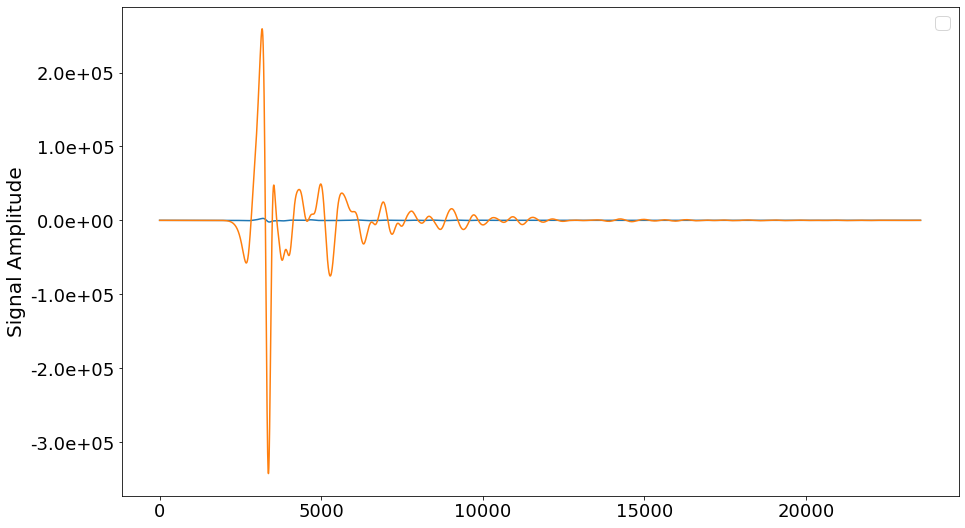

In [22]:
import matplotlib.ticker as ticker

fig, (ax1) = plt.subplots(figsize=(15,9),nrows=1, gridspec_kw={'height_ratios': [1]})
#ax1.set_title(r'Spatial Gradients - Constant $\rho$ Model', fontsize=20)


ax1.plot(VEL_Z[12,12,0])
ax1.plot(VEL_Z2[12,12,0])
#ax1.plot(VEL_Z[12,12,0]-VEL_Z2[12,12,0])
#ax1.set_ylim([1.1*np.min(U_LAPLACE_CST_true[posX,posY,:]),1.1*np.max(U_LAPLACE_CST_true[posX,posY,:])])
ax1.set_ylabel('Signal Amplitude',fontsize=20)
#ax1.set_xlim([dt_sub,3-dt_sub])
ax1.xaxis.set_tick_params(labelsize=18)
ax1.yaxis.set_tick_params(labelsize=18)
ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1e'))
ax1.legend(fontsize=18, loc='upper right')


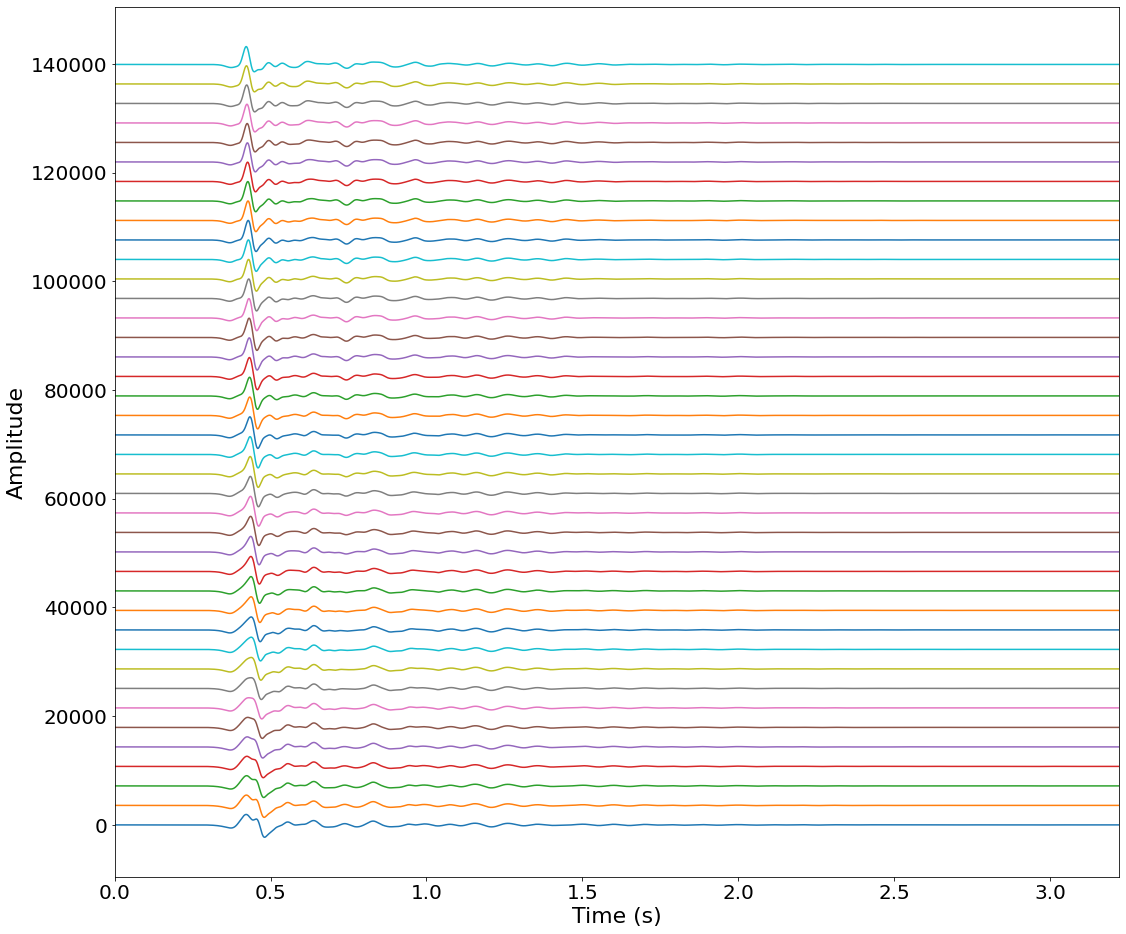

In [23]:
# Plot receiver section from y=700 m to y=1100 m

fig,ax = plt.subplots(figsize=(18,16))
ymax = VEL_Z.ravel().max()
t =np.linspace(0,PARA['nt']*PARA['dt'],PARA['nt'])
for k in range(nr):
     plt.plot(t, VEL_Z[12,k,0, :] + ymax *k)
     #print(ymax *k)
     plt.xlabel('Time (s)', fontsize = 22)
     plt.ylabel('Amplitude', fontsize = 22)
     ax.yaxis.set_tick_params(labelsize=20)
     ax.xaxis.set_tick_params(labelsize=20)
     ax.set_xlim([t[0],t[-1]])
plt.show()

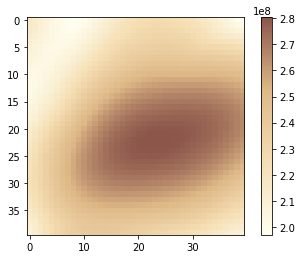

In [24]:
plt.imshow(abs(VEL_Z[:,:,0,:]-VEL_Z2[:,:,0,:]).sum(2))
plt.colorbar()

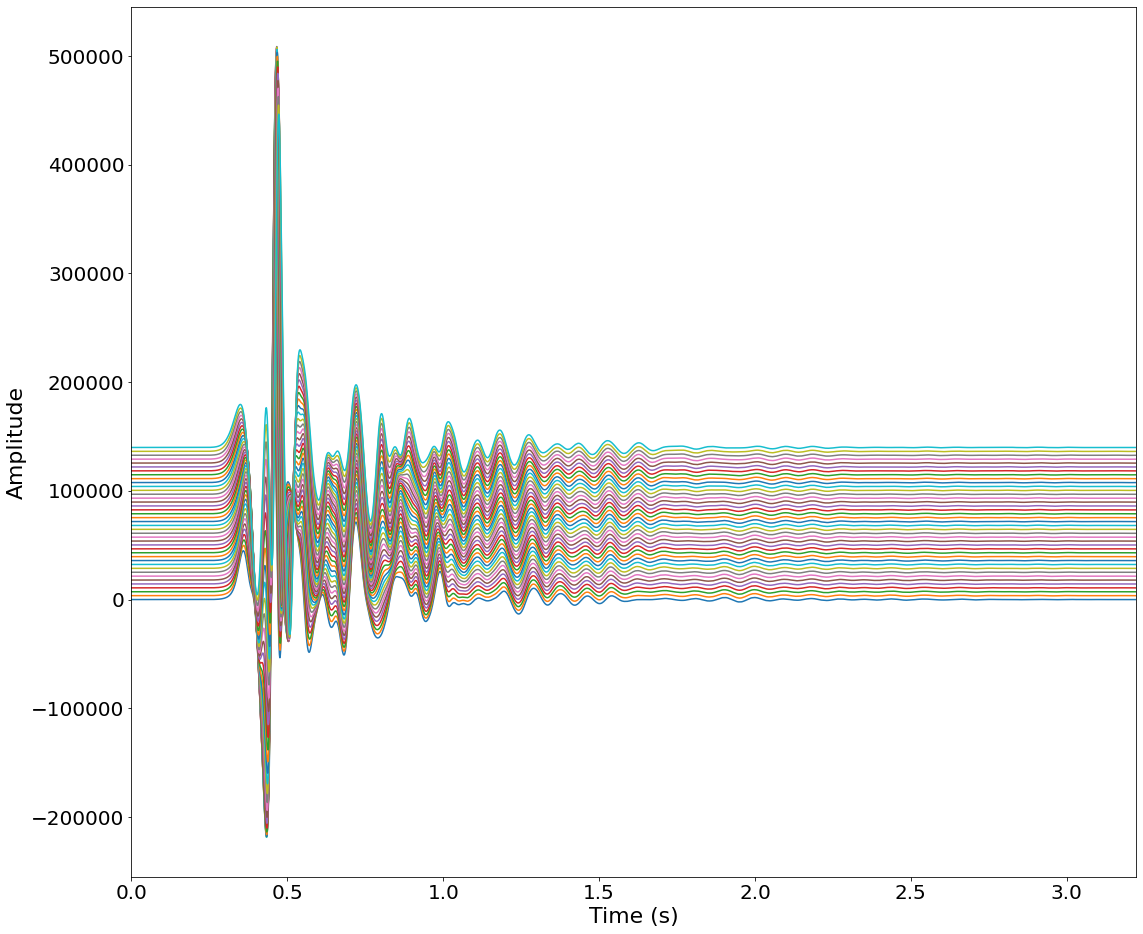

In [25]:
# Plot receiver section from y=700 m to y=1100 m

fig,ax = plt.subplots(figsize=(18,16))
ymax = VEL_Z.ravel().max()#-VEL_Z2.ravel().max()
t =np.linspace(0,PARA['nt']*PARA['dt'],PARA['nt'])
for k in range(nr):
     plt.plot(t,(VEL_Z[k,12,0, :]-VEL_Z2[k,12,0, :]) + ymax *k)
     #print(ymax *k)
     plt.xlabel('Time (s)', fontsize = 22)
     plt.ylabel('Amplitude', fontsize = 22)
     ax.yaxis.set_tick_params(labelsize=20)
     ax.xaxis.set_tick_params(labelsize=20)
     ax.set_xlim([t[0],t[-1]])
plt.show()

No handles with labels found to put in legend.


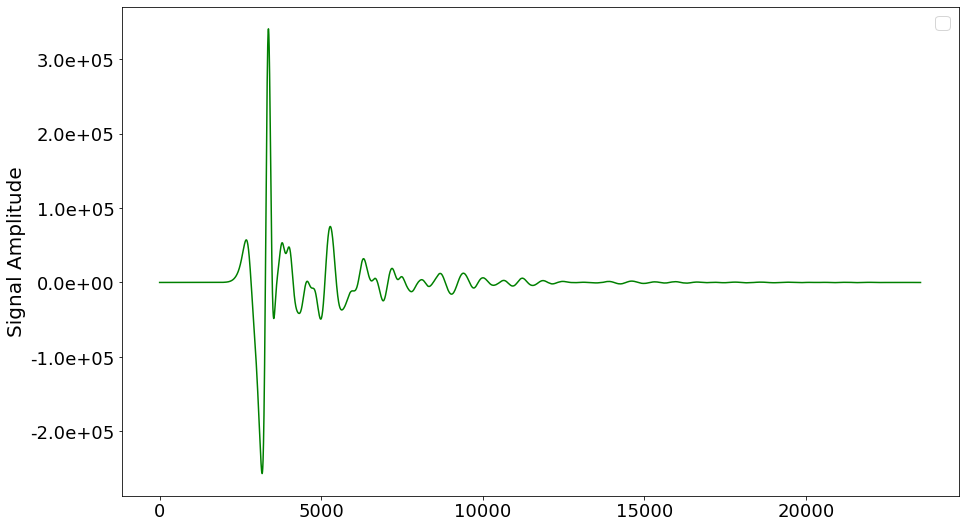

In [26]:
fig, (ax1) = plt.subplots(figsize=(15,9),nrows=1, gridspec_kw={'height_ratios': [1]})
#ax1.set_title(r'Spatial Gradients - Constant $\rho$ Model', fontsize=20)

ax1.plot(VEL_Z[12,12,0]-VEL_Z2[12,12,0], color='green')
#ax1.set_ylim([1.1*np.min(U_LAPLACE_CST_true[posX,posY,:]),1.1*np.max(U_LAPLACE_CST_true[posX,posY,:])])
ax1.set_ylabel('Signal Amplitude',fontsize=20)
#ax1.set_xlim([dt_sub,3-dt_sub])
ax1.xaxis.set_tick_params(labelsize=18)
ax1.yaxis.set_tick_params(labelsize=18)
ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1e'))
ax1.legend(fontsize=18, loc='upper right')

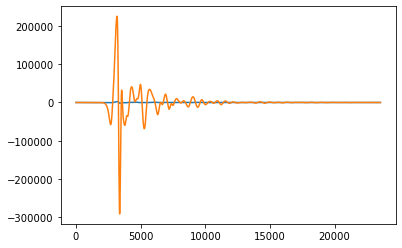

In [27]:
plt.plot(VEL_Z[10,10,0])
plt.plot(VEL_Z2[10,10,0])

In [28]:
test=np.reshape(np.asarray(rec_list), (nr,nr,3,3))
test[2,2,0]

array([265., 265., 300.])

In [29]:
OUT

<xarray.Dataset>
Dimensions:    (station_n: 4800, time: 23544)
Coordinates:
  * station_n  (station_n) object 'XX.000000.' 'XX.000001.' ... 'XX.393902.'
  * time       (time) int64 0 1 2 3 4 5 ... 23538 23539 23540 23541 23542 23543
Data variables:
    Pressure   (station_n, time) float64 0.0 0.0 0.0 0.0 ... 5.85 5.82 5.792

### Normalization

In [30]:
def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
       return v
    return v / norm

normalise = 'yes'

#VEL_ZZ = np.zeros((VEL_Z.shape))
if normalise =='yes':
#                 for l in range(0,nr): 
#                     for k in range(0,nr):
#                         for m in range(0,3):
#                             VEL_ZZ[l,k,m,:] = normalize(VEL_Z[l,k,m,:])
                VEL_Z = normalize(VEL_Z)#VEL_ZZ
                VEL_Z2 = normalize(VEL_Z2)

### Position

In [31]:

# Surface Receiver position
posX = 2 
posY = 2

# Depth level 
posZ = 0 

### Spectrogram

(0.0, 30.0)

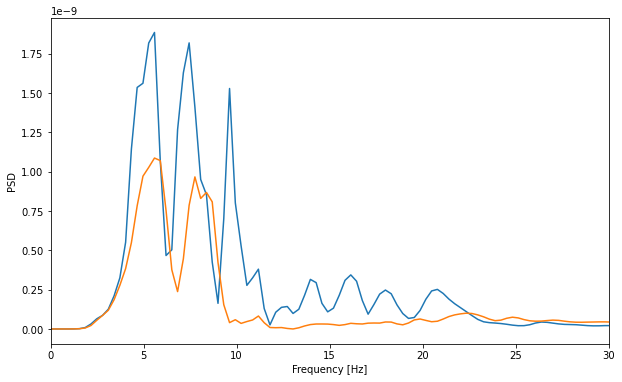

In [32]:
from scipy import signal
f, t, Sxx = signal.spectrogram(VEL_Z[posX,posY,posZ,:],fs=1/PARA['dt'],window=('tukey', 0.1), nperseg=None, noverlap=None)
fff, Pxx = signal.periodogram(VEL_Z[posX,posY,posZ,:],fs=1/PARA['dt'])

f2, t2, Sxx2 = signal.spectrogram(VEL_Z2[posX,posY,posZ,:],fs=1/PARA2['dt'],window=('tukey', 0.1), nperseg=None, noverlap=None)
fff2, Pxx2 = signal.periodogram(VEL_Z2[posX,posY,posZ,:],fs=1/PARA2['dt'])


fig, axs = plt.subplots(figsize=(10,6))

plt.plot(fff,Pxx)
plt.plot(fff2,Pxx2)

plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD')
plt.xlim(0,30)

### Filtering

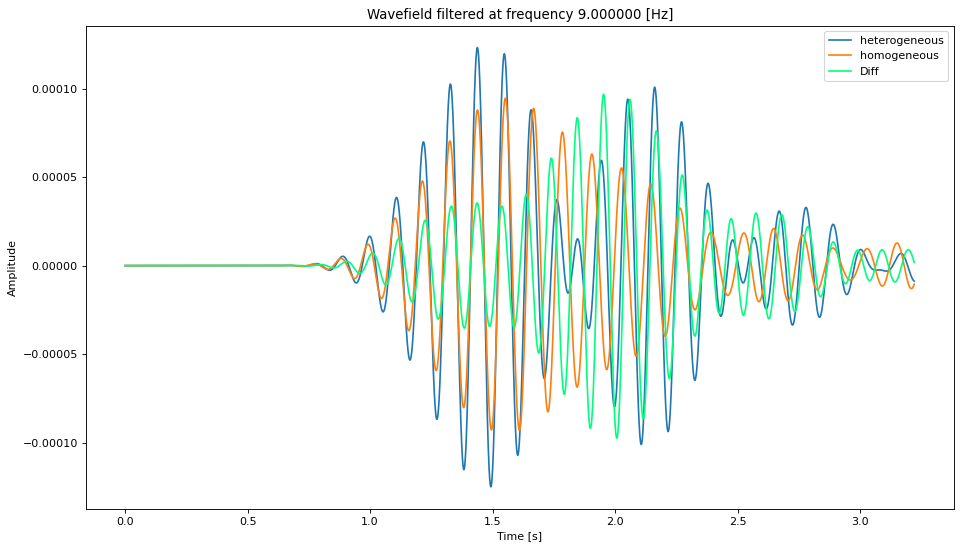

In [33]:
# Bandbass Filter
t = np.linspace(0,PARA['nt']*PARA['dt'], PARA['nt'])
t2 = np.linspace(0,PARA2['nt']*PARA2['dt'], PARA2['nt'])

nn = np.array([7])#4#([0.01]) 18 ###0.1
mm = np.array([9])#12#([70]) 25     ###6
f_BAND = np.array([nn,mm])


U_filt_Z = np.zeros((VEL_Z.shape[0],VEL_Z.shape[1], nrz, VEL_Z.shape[3],len(f_BAND[0,:])))
U_filt_Z2 = np.zeros((VEL_Z2.shape[0],VEL_Z2.shape[1], nrz, VEL_Z2.shape[3],len(f_BAND[0,:])))
DIVP = np.zeros((VEL_Z2.shape[0],VEL_Z2.shape[1], nrz, VEL_Z2.shape[3],len(f_BAND[0,:])))

for dd in range(nrz):


        U_filterZ, f_filt_cent = BP_filter(VEL_Z[:,:,dd,:], f_BAND, PARA['dt'], posX, posY, t)
        U_filt_Z[:,:,dd,:,:] = np.reshape(U_filterZ, (U_filt_Z[:,:,dd,:,:].shape))
        U_filterZ2, f_filt_cent2 = BP_filter(VEL_Z2[:,:,dd,:], f_BAND, PARA['dt'], posX, posY, t)
        U_filt_Z2[:,:,dd,:,:] = np.reshape(U_filterZ2, (U_filt_Z2[:,:,dd,:,:].shape))


nf = 0
plt.figure(num=None, figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(t, U_filt_Z[posX,posY,posZ,:,nf], label='heterogeneous')
plt.plot(t2, U_filt_Z2[posX,posY,posZ,:,nf], label='homogeneous')
plt.plot(t2, U_filt_Z[posX,posY,posZ,:,nf]-U_filt_Z2[posX,posY,posZ,:,nf], label='Diff', color='springgreen')

plt.title('Wavefield filtered at frequency %f [Hz]' %np.round(f_filt_cent[nf],2))
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()
plt.show() 
    
ll = len(f_filt_cent)
    

In [34]:
f_BAND

array([[ 8],
       [10]])

In [35]:
f_BAND

array([[ 8],
       [10]])

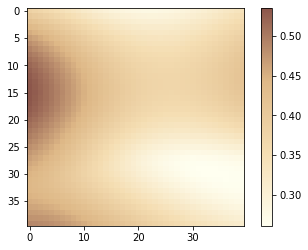

In [36]:
DI=abs(U_filt_Z[:,:,0,:,nf]-U_filt_Z2[:,:,0,:,nf])
plt.imshow(DI.sum(2))
plt.colorbar()

In [37]:
t2.shape

(23544,)

In [38]:
AMP = np.zeros((nr,nr))

for l in range(0,nr): 
        for k in range(0,nr):

            AMP[l,k] = np.max( U_filt_Z[l,k,0,:,0])

### Subsampling

In [39]:
# Spatial Subsampling of true model
# Get velocity, density and attenuation fields at receiver points

rxx=nr
ryy=nr
rzz = nrz

grid_pos = 'full'

Rx = (np.linspace(PARA['rec_grid_pos'][0], PARA['rec_grid_pos'][2], nr).astype(int) -1).tolist()
Ry = (np.linspace(PARA['rec_grid_pos'][1], PARA['rec_grid_pos'][3], nr).astype(int) -1).tolist()
Rz = (np.linspace(PARA['rec_grid_pos'][4], PARA['rec_grid_pos'][5], nrz).astype(int) -1 ).tolist()

vp_sub_INPUT     = ds_without_q.vp.values[:,:,Rz]
vp_sub_INPUT     = vp_sub_INPUT[Rx,:,:]
vp_sub_INPUT     = np.asarray(vp_sub_INPUT[:,Ry,:])

rho_grad_INPUT   = ds_without_q.rho.values[:,:,Rz]
rho_grad_INPUT   = rho_grad_INPUT[Rx,:,:]
rho_grad_INPUT   = np.asarray(rho_grad_INPUT[:,Ry,:])

vp_sub     = model_true.VP[:,:,Rz].values #ds_without_q.vp.values[:,:,Rz]
vp_sub     = vp_sub[Rx,:,:]
vp_sub     = np.asarray(vp_sub[:,Ry,:])

rho_grad   = model_true.RHO[:,:,Rz].values #ds_without_q.rho.values[:,:,Rz]
rho_grad   = rho_grad[Rx,:,:]
rho_grad   = np.asarray(rho_grad[:,Ry,:])

if grid_pos =='half':
    
    Rx = (np.linspace(PARA['rec_grid_pos'][0], PARA['rec_grid_pos'][2], nr).astype(int) -1 ).tolist()
    Ry = (np.linspace(PARA['rec_grid_pos'][1], PARA['rec_grid_pos'][3], nr).astype(int) -1 ).tolist()
    Rz = (np.linspace(PARA['rec_grid_pos'][4], PARA['rec_grid_pos'][5], nrz).astype(int) -1 ).tolist()

    Rxx= (np.linspace(PARA['rec_grid_pos'][0], PARA['rec_grid_pos'][2], nr).astype(int)+1  ).tolist()
    Ryy= (np.linspace(PARA['rec_grid_pos'][1], PARA['rec_grid_pos'][3], nr).astype(int)+1  ).tolist()
    
    rho_grad1   = ds_without_q.rho.values[:,:,Rz]
    rho_grad1   = rho_grad1[Rx,:,:]
    rho_grad1   = np.asarray(rho_grad1[:,Ry,:])

    rho_grad2   = ds_without_q.rho.values[:,:,Rz]#ds_without_q.rho[:,:,Rz] #model_true.RHO[:,:,Rz]
    rho_grad2   = rho_grad2[Rxx,:,:]
    rho_grad2   = rho_grad2[:,Ryy,:]
    rho_grad    = (rho_grad1.values+rho_grad2.values)/2

    vp_sub1     = ds_without_q.vp.values[:,:,Rz] #
    vp_sub1     = vp_sub1[Rx,:,:]
    vp_sub1     = np.asarray(vp_sub1[:,Ry,:])

    vp_sub2     = ds_without_q.vp.values[:,:,Rz] #
    vp_sub2     = vp_sub2[Rxx,:,:]
    vp_sub2     = np.asarray(vp_sub2[:,Ryy,:])
    vp_sub = (vp_sub1+vp_sub2)/2

c_sub      = vp_sub # 0.9*vs_sub

#qkappa_sub = ds_without_q.qkappa.values[Rx[0]:Rx[-1]+1,Ry[0]:Ry[-1]+1,Rz[-1]:Rz[0]+1]
#qkappa_sub = qkappa_sub[:,:,::-1]
#qmu_sub    = ds_with_q.qmu.values[Rx[0]:Rx[-1]+1,Ry[0]:Ry[-1]+1,Rz[-1]:Rz[0]+1]
#qmu_sub = qmu_sub[:,:,::-1]
#Qp = 1/(((1-(vs_sub**2)/(vp_sub**2))*(1/qkappa_sub)) + ((vs_sub**2)/(vp_sub**2)*(1/qmu_sub)))
#Qs = qmu_sub   


In [40]:
# Potential temporal subsampling
sub= 10  
sub2= 10 
nt_sub = np.ceil(PARA['nt']/sub).astype(int) 
dt_sub = sub* PARA['dt']
t_sub  = np.linspace(0,nt_sub*dt_sub, nt_sub)

nt_sub2 = np.ceil(PARA2['nt']/sub).astype(int) 
dt_sub2 = sub2* PARA2['dt']
t_sub2  = np.linspace(0,nt_sub2*dt_sub2, nt_sub2)

#Potential spatial sampling
dx = PARA['dist_X']
dy = PARA['dist_Y']
dz = PARA['dist_Z']

sub_spXY = 2
dx = dx*sub_spXY
dy = dy*sub_spXY
sub_spZ  = 1
dz = dz*sub_spZ
dist_r=dist_r*sub_spXY
nr  = int(nr/sub_spXY)
rxx = int(rxx/sub_spXY)
ryy = int(ryy/sub_spXY)
nrz = int(nrz/sub_spZ)
rzz = int(rzz/sub_spZ)

  
u_field_Z =   U_filt_Z[::sub_spXY,::sub_spXY,::sub_spZ,::sub,:]
u_field_Z2 =   U_filt_Z2[::sub_spXY,::sub_spXY,::sub_spZ,::sub,:]


vp_subTRUE = vp_sub[:,:,:]   
rho_gradTRUE = rho_grad[:,:,:]
vp_sub = vp_sub[::sub_spXY,::sub_spXY,::sub_spZ]
c_sub = vp_sub
#vs_sub = vs_sub[::sub_spXY,::sub_spXY,::sub_spZ]
rho_grad = rho_grad[::sub_spXY,::sub_spXY,::sub_spZ]

AMP = AMP[::sub_spXY,::sub_spXY]

In [41]:
dt_sub

0.0013683608340735723

In [42]:
PARA['dist_X']

2.0

## Gradient Calculation

In [43]:
# First Order

order = 2
#check order 4
VEL_X_gradX, VEL_Y_gradX, VEL_Z_gradX, VEL_X_gradY, VEL_Y_gradY, VEL_Z_gradY, VEL_X_gradZ, VEL_Y_gradZ, VEL_Z_gradZ \
= _1st_DER(u_field_Z, u_field_Z, u_field_Z, dx, dy, dz, 20,20,3, order)

divP = VEL_Z_gradX + VEL_Z_gradY

VEL_X_gradX2, VEL_Y_gradX2, VEL_Z_gradX2, VEL_X_gradY2, VEL_Y_gradY2, VEL_Z_gradY2, VEL_X_gradZ2, VEL_Y_gradZ2, VEL_Z_gradZ2 \
= _1st_DER(u_field_Z2, u_field_Z2, u_field_Z2, dx, dy, dz, 20,20,3, order)

divP2 = VEL_Z_gradX2 + VEL_Z_gradY2

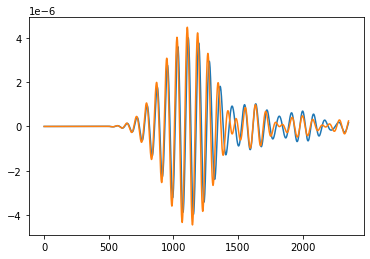

In [44]:
plt.plot(divP[2,2,0])
plt.plot(divP2[2,2,0])

In [45]:
divP.shape

(20, 20, 3, 2355, 1)

In [46]:
nr=20

In [47]:
import FCT_GRADIOMETRY_good_loop
from FCT_GRADIOMETRY_good_loop import *

dist_r=4
dx=4
dy=4
U_LAPLACE_CST_true, Utt_LAPLACE_CST_true, prod , Dxx_VAR = GRAD_LAPLACE_CST(dist_r, u_field_Z[:,:,0,1:-1,:], nt_sub-2, nr, nr, dt_sub, 2, f_filt_cent)
U_LAPLACE_CST2_true, Utt_LAPLACE_CST2_true, prod , Dxx_VAR = GRAD_LAPLACE_CST(dist_r, u_field_Z2[:,:,0,1:-1,:], nt_sub2-2, nr, nr, dt_sub2, 2, f_filt_cent)

rho_m_sub = rho_grad[:,:,0]
U_LAPLACE_VAR_true, Utt_LAPLACE_VAR_true, prod , Dxx_VAR = GRAD_LAPLACE_VAR(dist_r, u_field_Z[:,:,0,1:-1,:], nt_sub-2, nr, nr, dt_sub, rho_m_sub, f_filt_cent)
c_inv =  np.ones((nr,nr))#pd.read_csv(fig_+'/c_phase_VAR_inv_8').values
rho_m_sub = np.ones((rho_grad[:,:,0].shape))*1600
U_LAPLACE_VAR_true2, Utt_LAPLACE_VAR_true2, prod , Dxx_VAR = GRAD_LAPLACE_VAR(dist_r, u_field_Z2[:,:,0,1:-1,:], nt_sub2-2, nr, nr, dt_sub2, rho_m_sub, f_filt_cent)


In [48]:
ll = len(f_filt_cent)
ordd=0
comp = 'Z'
U_LAPLACE_CST2_trueRE  = np.reshape(U_LAPLACE_CST2_true, (nr,nr,1,nt_sub2-2,1))
Utt_LAPLACE_CST2_trueRE= np.reshape(Utt_LAPLACE_CST2_true, (nr,nr,1,nt_sub2-2,1))
c_phase_Z_2D_CSTRHO, mZ_2D_CSTRHO, r_sq_Z_2D_CSTRHO = LinReg_c(U_LAPLACE_CST2_trueRE[:,:,:,:,:],Utt_LAPLACE_CST2_trueRE[:,:,:,:,:], nt_sub2-2, ll, nr**2, nr, nr, 1,ordd)

U_LAPLACE_VAR2_trueRE  = np.reshape(U_LAPLACE_VAR_true2, (nr,nr,1,nt_sub2-2,1))
Utt_LAPLACE_VAR2_trueRE= np.reshape(Utt_LAPLACE_VAR_true2, (nr,nr,1,nt_sub2-2,1))
c_phase_Z_2D_CSTRHO_VAR, mZ_2D_CSTRHO_VAR, r_sq_Z_2D_CSTRHO_VAR = LinReg_c(U_LAPLACE_VAR2_trueRE[:,:,:,:,:],Utt_LAPLACE_VAR2_trueRE[:,:,:,:,:], nt_sub2-2, ll, nr**2, nr, nr, 1,ordd)

In [49]:
c_phase_Z_2D_CSTRHO_VAR[1:-1,1:-1,0,0]==c_phase_Z_2D_CSTRHO[1:-1,1:-1,0,0]

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True],

In [50]:
ordd=0
comp = 'Z'
U_LAPLACE_CST_trueRE  = np.reshape(U_LAPLACE_CST_true, (nr,nr,1,nt_sub-2,1))
Utt_LAPLACE_CST_trueRE= np.reshape(Utt_LAPLACE_CST_true, (nr,nr,1,nt_sub-2,1))
c_phase_Z_2D_CST, mZ_2D_CST, r_sq_Z_2D_CST = LinReg_c(U_LAPLACE_CST_trueRE[:,:,:,:,:],Utt_LAPLACE_CST_trueRE[:,:,:,:,:], nt_sub-2, ll, nr**2, nr, nr, 1,ordd)

In [51]:
U_LAPLACE_VAR_trueRE  = np.reshape(U_LAPLACE_VAR_true, (nr,nr,1,nt_sub-2,1))
Utt_LAPLACE_VAR_trueRE= np.reshape(Utt_LAPLACE_VAR_true, (nr,nr,1,nt_sub-2,1))
c_phase_Z_2D_VARRHO_VAR, mZ_2D_VARRHO_VAR, r_sq_Z_2D_VARRHO_VAR = LinReg_c(U_LAPLACE_VAR_trueRE[:,:,:,:,:],Utt_LAPLACE_VAR_trueRE[:,:,:,:,:], nt_sub-2, ll, nr**2, nr, nr, 1,ordd)

In [52]:
dc_VAR = 100* (c_phase_Z_2D_VARRHO_VAR[:,:,0,0] - c_phase_Z_2D_CSTRHO[:,:,0,0])/c_phase_Z_2D_CSTRHO[:,:,0,0]
to_export = pd.DataFrame(dc_VAR[:,:])
to_export.to_csv(fig_+'/dc_VAR_'+str(round(f_filt_cent[0])), index=False)

In [53]:
to_export = pd.DataFrame(r_sq_Z_2D_CSTRHO[:,:,0,0])
to_export.to_csv(fig_+'/r_sq_BASELINE_'+str(round(f_filt_cent[0])), index=False)

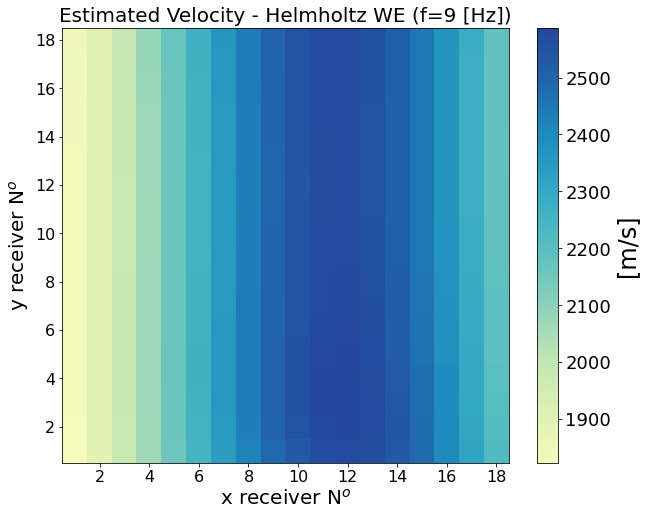

In [54]:
c_phase = c_phase_Z_2D_CSTRHO[:,:,0,0]
to_export = pd.DataFrame(c_phase_Z_2D_CSTRHO[:,:,0,0])
to_export.to_csv(fig_+'/c_BASELINE_'+str(round(f_filt_cent[0])), index=False)

fig,ax = plt.subplots(figsize=(10,8))
plt.title('Estimated Velocity - Helmholtz WE (f=%d [Hz])' %f_filt_cent[nf], size=20) 
im2=plt.imshow(c_phase[1:-1,1:-1] ,vmin=np.min(c_phase[1:-1,1:-1]), vmax=np.max(c_phase[1:-1,1:-1]), aspect='auto', interpolation='none', cmap=YlGnBu,origin='lower' ,extent=[0.5, nr-2+0.5, 0.5, nr-2+0.5]) #,extent=[-3, 3, -3, 3]
#plt.gca().invert_yaxis()
cbar = plt.colorbar(im2, format='%.0f')
cbar.set_label(label='[m/s]',size=24)
for t in cbar.ax.get_yticklabels():
         t.set_fontsize(18)
plt.xlabel(r'x receiver N$^{o}$',fontsize=20)
plt.ylabel(r'y receiver N$^{o}$',fontsize=20)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)


plt.show() 

In [55]:
# fff_new = np.array([4,5,6,7,8,9,10,11,12,13,14])
# i=0
# cBASE_TEST=np.zeros((nr,nr,len(fff_new)))
# cBASE=np.zeros((nr,nr,len(fff_new)))
# for ff in fff_new: 
#     cBASE_TEST[:,:,i] = pd.read_csv(fig_+'/c_BASELINE2_'+str(round(ff)))
#     cBASE[:,:,i] = pd.read_csv(fig_+'/c_BASELINE_'+str(round(ff)))
#     i=i+1

In [56]:
# plt.plot(cBASE_TEST[1:-1,1:-1,:].mean(axis=0).mean(axis=0))
# plt.plot(cBASE[1:-1,1:-1,:].mean(axis=0).mean(axis=0))

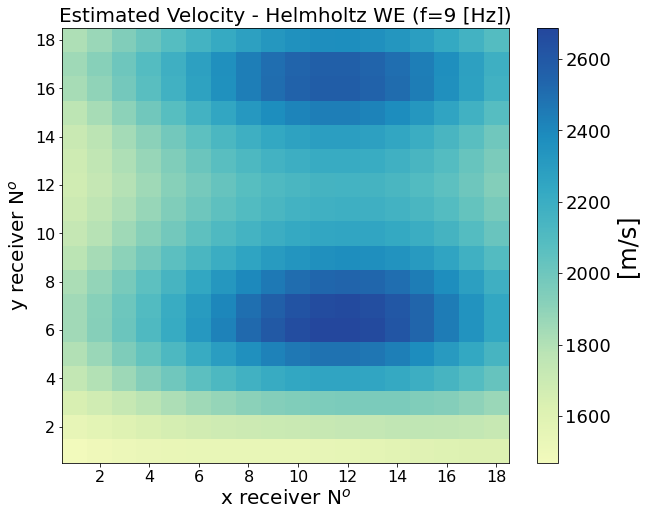

In [57]:
c_phase = c_phase_Z_2D_CST[:,:,0,0]
to_export = pd.DataFrame(c_phase_Z_2D_CSTRHO[:,:,0,0])
#to_export.to_csv(fig_+'/c_BASELINE_'+str(round(f_filt_cent[0])), index=False)

fig,ax = plt.subplots(figsize=(10,8))
plt.title('Estimated Velocity - Helmholtz WE (f=%d [Hz])' %f_filt_cent[nf], size=20) 
im2=plt.imshow(c_phase[1:-1,1:-1] ,vmin=np.min(c_phase[1:-1,1:-1]), vmax=np.max(c_phase[1:-1,1:-1]), aspect='auto', interpolation='none', cmap=YlGnBu,origin='lower' ,extent=[0.5, nr-2+0.5, 0.5, nr-2+0.5]) #,extent=[-3, 3, -3, 3]
#im2=plt.imshow(c_phase[1:-1,1:-1] ,vmin=800, vmax=1300, aspect='auto', interpolation='none', cmap=YlGnBu,origin='lower' ,extent=[0.5, nr-2+0.5, 0.5, nr-2+0.5]) #,extent=[-3, 3, -3, 3]
#plt.gca().invert_yaxis()
cbar = plt.colorbar(im2, format='%.0f')
cbar.set_label(label='[m/s]',size=24)
for t in cbar.ax.get_yticklabels():
         t.set_fontsize(18)
plt.xlabel(r'x receiver N$^{o}$',fontsize=20)
plt.ylabel(r'y receiver N$^{o}$',fontsize=20)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)


plt.show() 

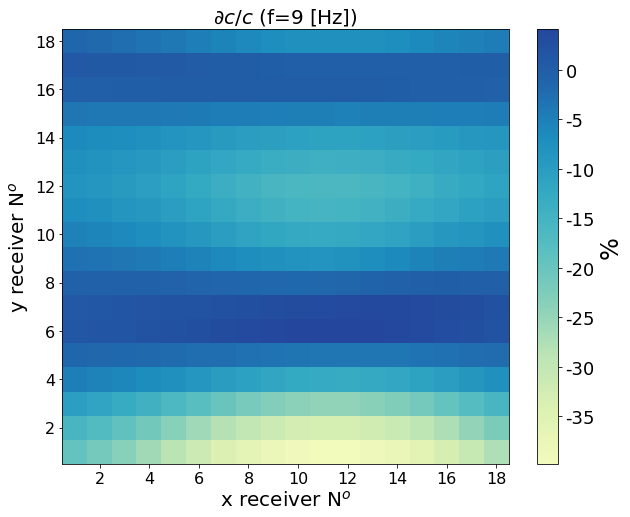

In [58]:
dc = 100* (c_phase_Z_2D_CST[:,:,0,0] - c_phase_Z_2D_CSTRHO[:,:,0,0])/c_phase_Z_2D_CSTRHO[:,:,0,0]
to_export = pd.DataFrame(dc[:,:])
to_export.to_csv(fig_+'/dc_'+str(round(f_filt_cent[0])), index=False)

fig,ax = plt.subplots(figsize=(10,8))
plt.title(r'$\partial c/ c$ (f=%d [Hz])' %f_filt_cent[nf], size=20) 
im2=plt.imshow(dc[1:-1,1:-1] ,vmin=np.min(dc[1:-1,1:-1]), vmax=np.max(dc[1:-1,1:-1]), aspect='auto', interpolation='none', cmap=YlGnBu,origin='lower' ,extent=[0.5, nr-2+0.5, 0.5, nr-2+0.5]) #,extent=[-3, 3, -3, 3]
#plt.gca().invert_yaxis()
cbar = plt.colorbar(im2, format='%.0f')
cbar.set_label(label='%',size=24)
for t in cbar.ax.get_yticklabels():
         t.set_fontsize(18)
plt.xlabel(r'x receiver N$^{o}$',fontsize=20)
plt.ylabel(r'y receiver N$^{o}$',fontsize=20)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)


plt.show() 

In [59]:
c_phase[12,12]

2155.919877471622

In [60]:
c_phase[5,10]

2462.8263866083885

In [61]:
rho_grad[5,10,0]

1217.4625506933849

In [62]:
grad = (rho_grad[4,10,0]-rho_grad[6,10,0])/ 8
grad

5.204429273418782

In [63]:
print('Density perturbation of:',100*grad/rho_grad[5,10,0], '%')


Density perturbation of: 0.42748167247154245 %


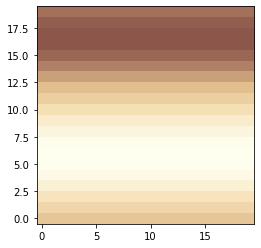

In [64]:
plt.imshow(rho_grad[:,:,0],origin='lower')

In [65]:
d_obs_BASE = Utt_LAPLACE_CST2_true[:,:,1:-1,0]
d_pred_BASE = (c_phase_Z_2D_CSTRHO[:,:,0,0,np.newaxis]**2) * U_LAPLACE_CST2_true[:,:,1:-1,0]

residual_BASE = (d_obs_BASE-d_pred_BASE)
J_BASE =   ((d_obs_BASE-d_pred_BASE))**2
J_BASE = ( 1/(nt_sub-2) * J_BASE.sum(2))

to_export = pd.DataFrame(J_BASE[:,:])
to_export.to_csv(fig_+'/J_BASE*'+'_'+str(round(f_filt_cent[0])), index=False)


In [66]:
grid_signal = np.zeros((nr,nr))
USP_norm = np.zeros((nr,nr, nt_sub-4))
for i in range(0,nr):
    for j in range(0,nr):
        grid_signal[i,j] = (1/U_LAPLACE_CST_true[i,j,1:-1].shape[0])*abs((U_LAPLACE_VAR_true[i,j,1:-1]/np.max(U_LAPLACE_VAR_true[i,j,1:-1]))-(U_LAPLACE_CST_true[i,j,1:-1]/np.max(U_LAPLACE_CST_true[i,j,1:-1]))).sum(0)
        USP_norm[i,j,:]    = abs(U_LAPLACE_VAR_true[i,j,1:-1,0]/np.max(U_LAPLACE_VAR_true[i,j,1:-1,0]))
                               
print(np.mean(grid_signal[1:-1,1:-1]))
fingerprint = grid_signal

to_export = pd.DataFrame(fingerprint)
to_export.to_csv(fig_+'/fingerprint'+'_'+str(round(f_filt_cent[0])), index=False)

USP_norm_grid = USP_norm.sum(2)/(nt_sub-4)
#print(USP_norm_grid)
print(100* np.mean(fingerprint[1:-1,1:-1])/np.mean(USP_norm_grid[1:-1,1:-1]) )

to_export = pd.DataFrame(USP_norm_grid)
to_export.to_csv(fig_+'/USP_norm_grid'+'_'+str(round(f_filt_cent[0])), index=False)

0.0642521546137302
34.22699739314457


In [71]:
USP_norm.shape

(20, 20, 2351)

In [72]:
nt_sub

2355

In [67]:
np.mean(grid_signal[1:-1,1:-1])


0.0642521546137302

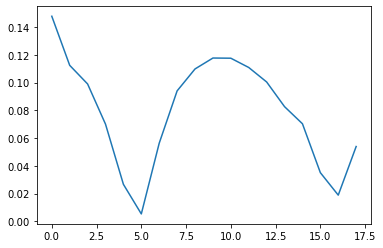

In [68]:
plt.plot(fingerprint[1:-1,12].flatten())

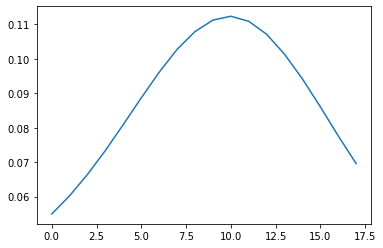

In [69]:
plt.plot(fingerprint[12,1:-1].flatten())

(0.6, 3.2)

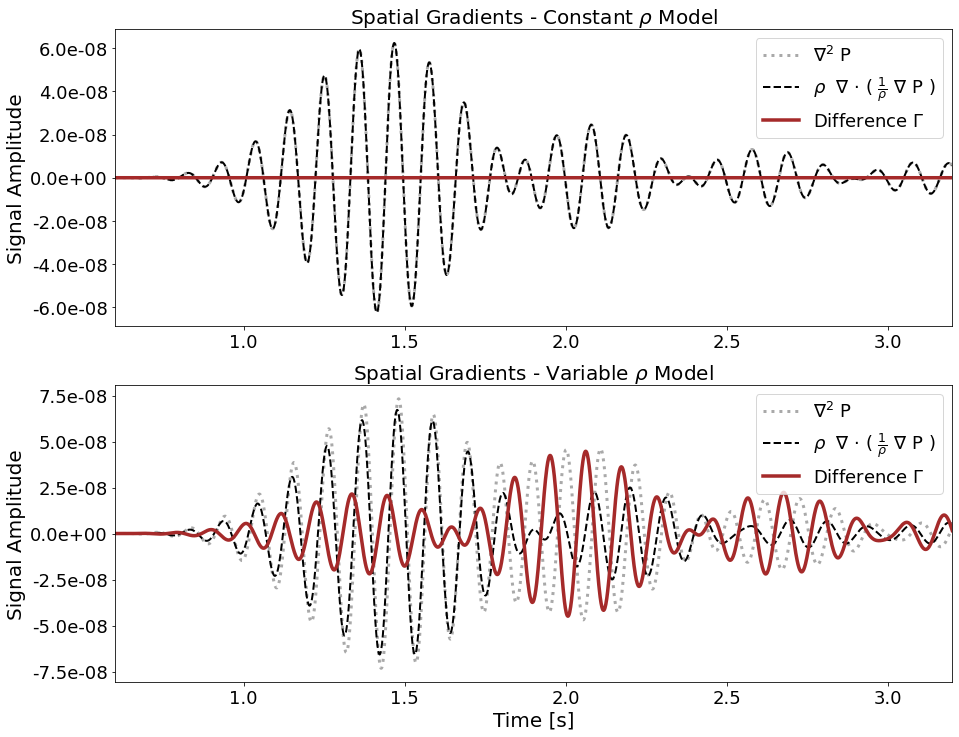

In [73]:
import matplotlib.ticker as ticker
posX=12
posY=12
time_vec = np.linspace(2*dt_sub,(nt_sub*dt_sub)-(2*dt_sub),nt_sub-4)
time_vec2 = np.linspace(2*dt_sub2,(nt_sub2*dt_sub2)-(2*dt_sub2),nt_sub2-4)

fig, (ax1,ax2) = plt.subplots(figsize=(15,12),nrows=2, gridspec_kw={'height_ratios': [1,1]})
#plt.suptitle('Elastic media', fontsize=28)
ax1.set_title(r'Spatial Gradients - Constant $\rho$ Model', fontsize=20)
ax1.plot(time_vec2,U_LAPLACE_CST2_true[posX,posY,1:-1], linewidth= 3, color='darkgrey',linestyle=':',label=r'$\nabla^{2}$ P')
#ax1.plot(time_vec2, rhs_BASE[posX,posY,:])
#ax1.plot(U_LAPLACE_CST_true[posX,posY,:], linewidth= 3, color='blue',label=r'[ $\nabla^{2}$ u]')
#ax1.plot(rhs_BASE[posX,posY,:]-U_LAPLACE_CST2_true[posX,posY,:],label='Misfit')


ax1.plot(time_vec2,U_LAPLACE_VAR_true2[posX,posY,1:-1], linewidth= 2, color='black',linestyle='--',label=r'$\rho$  $\nabla$ $\cdot$ ( $\frac{1}{\rho}$ $\nabla$ P )')
ax1.plot(time_vec2,U_LAPLACE_VAR_true2[posX,posY,1:-1]-U_LAPLACE_CST2_true[posX,posY,1:-1], linestyle='-', linewidth= 3.5, color='brown' , label=r'Difference $\Gamma$')
#ax1.set_ylim([1.1*np.min(U_LAPLACE_CST_true[posX,posY,:]),1.1*np.max(U_LAPLACE_CST_true[posX,posY,:])])

ax2.set_title(r'Spatial Gradients - Variable $\rho$ Model', fontsize=20)
ax2.plot(time_vec,U_LAPLACE_CST_true[posX,posY,1:-1], linewidth= 3, color='darkgrey',linestyle=':',label=r'$\nabla^{2}$ P')
ax2.plot(time_vec,U_LAPLACE_VAR_true[posX,posY,1:-1], linewidth= 2, color='black' , linestyle='--',label=r'$\rho$  $\nabla$ $\cdot$ ( $\frac{1}{\rho}$ $\nabla$ P )')
ax2.plot(time_vec,U_LAPLACE_VAR_true[posX,posY,1:-1]-U_LAPLACE_CST_true[posX,posY,1:-1], linestyle='-', linewidth= 3.5, color='brown' , label=r'Difference $\Gamma$')

#ax2.plot(time_vec,rhs[posX,posY,:,0], linewidth= 3, label=r'$\frac{1}{(c_{w})^{2}}$ $\delta_{t}^{2}$ P',linestyle=':', color='deepskyblue')
#ax2.plot(time_vec,rhs_helm[posX,posY,:,0], linewidth= 3, label=r'$\frac{1}{(c_{w})^{2}}$ $\delta_{t}^{2}$ P',linestyle=':', color='yellow')
#ax2.set_ylim([1.1*np.min(U_LAPLACE_CST_true[posX,posY,:]),1.1*np.max(U_LAPLACE_CST_true[posX,posY,:])])
#ax2.plot(time_vec,Utt_LAPLACE_CST_true[posX,posY,:], linewidth= 3, color='black',label=r'[ $\nabla^{2}$ P]')


#ax2.plot(-U_LAPLACE_VAR_true[posX,posY,:]+U_LAPLACE_VAR_true2[posX,posY,:], linestyle='-',linewidth= 2, color='yellow', label='Density Signal')
#ax2.plot(-U_LAPLACE_CST_true[posX,posY,:]+U_LAPLACE_CST2_true[posX,posY,:], linestyle='-',linewidth= 2, color='yellow', label='Density Signal')

#ax2.plot(time_vec,U_LAPLACE_VAR_true[posX,posY,:]-U_LAPLACE_CST_true[posX,posY,:], linestyle='-', linewidth= 4, color='black' , label='Density Signal')
#ax2.plot(time_vec,U_LAPLACE_VAR_true2[posX,posY,:]-U_LAPLACE_VAR_true[posX,posY,:], linestyle='-', linewidth= 4, color='black' , label='Density Signal')

#ax2.set_xlabel('Time [s]',fontsize=16)
ax2.set_ylabel('Signal Amplitude',fontsize=20)
ax1.set_ylabel('Signal Amplitude',fontsize=20)

ax1.set_xlim([dt_sub,3-dt_sub])
ax1.xaxis.set_tick_params(labelsize=18)
ax1.yaxis.set_tick_params(labelsize=18)
ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1e'))
ax1.legend(fontsize=18, loc='upper right')

ax2.set_xlim([dt_sub,3-dt_sub])
ax2.xaxis.set_tick_params(labelsize=18)
ax2.yaxis.set_tick_params(labelsize=18)
ax2.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1e'))
ax2.legend(fontsize=18, ncol=1, loc='upper right')
ax2.set_xlabel('Time [s]',fontsize=20)

ax1.set_xlim([0.2,2.8])
ax2.set_xlim([0.2,2.8])

ax1.set_xlim([0.8,2.5])
ax2.set_xlim([0.8,2.5])

ax1.set_xlim([0.6,3.2])
ax2.set_xlim([0.6,3.2])

# ax1.set_xlim([0.25,1.5])
# ax2.set_xlim([0.25,1.5])
# ax3.set_xlim([0.25,1.5])
#ax2.set_ylim([-3e-07,3e-07])

In [70]:
break

SyntaxError: 'break' outside loop (668683560.py, line 4)

In [ ]:
rho_signal = (U_LAPLACE_VAR_true[1:-1,1:-1,1:-1]-U_LAPLACE_CST_true[1:-1,1:-1,1:-1]).mean(axis=0).mean(axis=0)#.sum(0).sum(0)/(nr-2)**2

rho_norm = np.zeros((nr-2,nr-2,nt_sub-4,1))
for i in range(1,nr-2):
    for j in range(1,nr-2):
        rho_norm[i,j,:,:] = (U_LAPLACE_VAR_true[i,j,1:-1]/np.max(U_LAPLACE_VAR_true[i,j,1:-1]))-(U_LAPLACE_CST_true[i,j,1:-1]/np.max(U_LAPLACE_CST_true[i,j,1:-1]))
rho_signal_norm  = rho_norm[500:-1].mean(axis=0).mean(axis=0)

rho_signal_norm_abs  = abs(rho_norm).mean(axis=0).mean(axis=0)

rho_signal_norm_abs  = abs(rho_norm).mean(axis=0).mean(axis=0)

to_export = pd.DataFrame(rho_signal)
to_export.to_csv(fig_+'/rho_signal'+'_'+str(round(f_filt_cent[0])), index=False)

to_export = pd.DataFrame(rho_signal_norm)
to_export.to_csv(fig_+'/rho_signal_norm'+'_'+str(round(f_filt_cent[0])), index=False)

to_export = pd.DataFrame(rho_signal_norm_abs)
to_export.to_csv(fig_+'/rho_signal_norm_abs'+'_'+str(round(f_filt_cent[0])), index=False)

rho_signal_ABS = abs(U_LAPLACE_VAR_true[1:-1,1:-1,1:-1]-U_LAPLACE_CST_true[1:-1,1:-1,1:-1]).mean(axis=0).mean(axis=0)#.sum(0).sum(0)/(nr-2)**2

to_export = pd.DataFrame(rho_signal_ABS)
to_export.to_csv(fig_+'/rho_signal_ABS'+'_'+str(round(f_filt_cent[0])), index=False)

to_export = pd.DataFrame(U_LAPLACE_VAR_true[1:-1,1:-1,1:-1].mean(axis=0).mean(axis=0))
to_export.to_csv(fig_+'/UspVAR'+'_'+str(round(f_filt_cent[0])), index=False)

In [ ]:
rho_signal2 = (U_LAPLACE_VAR_true2[1:-1,1:-1,1:-1]-U_LAPLACE_VAR_true[1:-1,1:-1,1:-1]).mean(axis=0).mean(axis=0)#.sum(0).sum(0)/(nr-2)**2
rho_signal2_ABS = (abs(U_LAPLACE_VAR_true2[1:-1,1:-1,1:-1]-U_LAPLACE_VAR_true[1:-1,1:-1,1:-1])).mean(axis=0).mean(axis=0)#.sum(0).sum(0)/(nr-2)**2
#rho_signal2 = (U_LAPLACE_VAR_true2[2:-2,2:-2]-U_LAPLACE_VAR_true[2:-2,2:-2]).mean(axis=0).mean(axis=0)#.sum(0).sum(0)/(nr-2)**2
#rho_signal2_ABS = (abs(U_LAPLACE_VAR_true2[2:-2,2:-2]-U_LAPLACE_VAR_true[2:-2,2:-2])).mean(axis=0).mean(axis=0)#.sum(0).sum(0)/(nr-2)**2

to_export = pd.DataFrame(rho_signal2)
to_export.to_csv(fig_+'/rho_signal2'+'_'+str(round(f_filt_cent[0])), index=False)
to_export = pd.DataFrame(rho_signal2_ABS)
to_export.to_csv(fig_+'/rho_signal2_ABS'+'_'+str(round(f_filt_cent[0])), index=False)

In [ ]:
plt.imshow(abs(rho_norm[1:-1,1:-1]).sum(2)/rho_signal_norm.shape[0])
plt.colorbar()

In [ ]:
rho_norm.shape

In [ ]:
break

In [ ]:
#fff_new = np.array([8,12,18])
fff_new = np.array([4,5,6,7,8,9,10,11,12,13,14])

RHO_SIGNAL_NORM = np.zeros((fff_new.shape[0],1))
RHO_SIGNAL_NORM_abs  = np.zeros((fff_new.shape[0],1))
RHO_SIGNAL_RATIO = np.zeros((fff_new.shape[0],1))
RHO_SIGNAL_RATIO2 = np.zeros((fff_new.shape[0],1))
RHO_SIGNAL = np.zeros((fff_new.shape[0],1))
RHO_SIGNAL2 = np.zeros((fff_new.shape[0],1))
RHO_SIGNAL_RATIO_ABS = np.zeros((fff_new.shape[0],1))
RHO_SIGNAL_RATIO2_ABS = np.zeros((fff_new.shape[0],1))
FINGERPRINT = np.zeros((fff_new.shape[0],1))

USP= np.zeros((11,1))
i=0
for ff in fff_new: 
    USP[i,:] = (abs(pd.read_csv(fig_+'/UspVAR'+'_'+str(ff))).values.sum(0)/nt_sub)
    RHO_SIGNAL_RATIO_ABS[i,:] = (abs(pd.read_csv(fig_+'/rho_signal_ABS'+'_'+str(ff))).values.sum(0)/nt_sub) / (abs(pd.read_csv(fig_+'/UspVAR'+'_'+str(ff))).values.sum(0)/nt_sub)
    RHO_SIGNAL_RATIO2_ABS[i,:] = (abs(pd.read_csv(fig_+'/rho_signal2_ABS'+'_'+str(ff))).values.sum(0)/nt_sub) / (abs(pd.read_csv(fig_+'/UspVAR'+'_'+str(ff))).values.sum(0)/nt_sub)
    RHO_SIGNAL_RATIO[i,:] = (abs(pd.read_csv(fig_+'/rho_signal'+'_'+str(ff))).values.sum(0)/nt_sub) / (abs(pd.read_csv(fig_+'/UspVAR'+'_'+str(ff))).values.sum(0)/nt_sub)
    RHO_SIGNAL_RATIO2[i,:] = (abs(pd.read_csv(fig_+'/rho_signal2'+'_'+str(ff))).values.sum(0)/nt_sub) / (abs(pd.read_csv(fig_+'/UspVAR'+'_'+str(ff))).values.sum(0)/nt_sub)
    RHO_SIGNAL[i,:] = (abs(pd.read_csv(fig_+'/rho_signal'+'_'+str(ff)).values).sum(0)/nt_sub) 
    RHO_SIGNAL2[i,:] = (abs(pd.read_csv(fig_+'/rho_signal2'+'_'+str(ff))).values.sum(0)/nt_sub) 
    RHO_SIGNAL_NORM[i,:] = (abs(pd.read_csv(fig_+'/rho_signal_norm'+'_'+str(ff)).values).sum(0)/nt_sub) 
    RHO_SIGNAL_NORM_abs[i,:] = (abs(pd.read_csv(fig_+'/rho_signal_norm_abs'+'_'+str(ff)).values).sum(0)/nt_sub) 
    FINGERPRINT[i,:] = np.mean(pd.read_csv(fig_+'/fingerprint'+'_'+str(ff)).values)

    i=i+1

In [ ]:
pd.read_csv(fig_+'/fingerprint'+'_'+str(ff)).values.shape

In [ ]:
plt.imshow(pd.read_csv(fig_+'/fingerprint'+'_'+str(8)).values[1:-1,1:-1])
plt.colorbar()

In [ ]:
plt.scatter(FINGERPRINT,fff_new)


In [ ]:
plt.scatter(RHO_SIGNAL_RATIO,fff_new)
plt.scatter(RHO_SIGNAL_RATIO_ABS,fff_new)

In [ ]:
fff_new = np.array([4,5,6,7,8,9,10,11,12,13,14])
RHO_SIGNAL_RATIO = np.zeros((fff_new.shape[0],1))
RHO_SIGNAL_RATIO2 = np.zeros((fff_new.shape[0],1))
RHO_SIGNAL = np.zeros((fff_new.shape[0],1))
RHO_SIGNAL2 = np.zeros((fff_new.shape[0],1))
RHO_SIGNAL_RATIO_ABS = np.zeros((fff_new.shape[0],1))
RHO_SIGNAL_RATIO2_ABS = np.zeros((fff_new.shape[0],1))
#fff_new = np.array([4,6,8,10,12,14])
USP= np.zeros((12,1))
i=0
for ff in fff_new: 
    USP[i,:] = (abs(pd.read_csv(fig_+'/UspVAR'+'_'+str(ff))).values.sum(0)/nt_sub)
    RHO_SIGNAL_RATIO_ABS[i,:] = (abs(pd.read_csv(fig_+'/rho_signal_ABS'+'_'+str(ff))).values.sum(0)/nt_sub) / (abs(pd.read_csv(fig_+'/UspVAR'+'_'+str(ff))).values.sum(0)/nt_sub)
    RHO_SIGNAL_RATIO2_ABS[i,:] = (abs(pd.read_csv(fig_+'/rho_signal2_ABS'+'_'+str(ff))).values.sum(0)/nt_sub) / (abs(pd.read_csv(fig_+'/UspVAR'+'_'+str(ff))).values.sum(0)/nt_sub)
    RHO_SIGNAL_RATIO[i,:] = (abs(pd.read_csv(fig_+'/rho_signal'+'_'+str(ff))).values.sum(0)/nt_sub) / (abs(pd.read_csv(fig_+'/UspVAR'+'_'+str(ff))).values.sum(0)/nt_sub)
    RHO_SIGNAL_RATIO2[i,:] = (abs(pd.read_csv(fig_+'/rho_signal2'+'_'+str(ff))).values.sum(0)/nt_sub) / (abs(pd.read_csv(fig_+'/UspVAR'+'_'+str(ff))).values.sum(0)/nt_sub)
    RHO_SIGNAL[i,:] = (abs(pd.read_csv(fig_+'/rho_signal'+'_'+str(ff)).values).sum(0)/nt_sub) 
    RHO_SIGNAL2[i,:] = (abs(pd.read_csv(fig_+'/rho_signal2'+'_'+str(ff))).values.sum(0)/nt_sub) 

    i=i+1

In [ ]:
#plt.scatter(USP, fff_new)


In [ ]:
plt.scatter(RHO_SIGNAL, fff_new)
plt.scatter(RHO_SIGNAL2, fff_new)

In [ ]:
plt.scatter(100*RHO_SIGNAL_RATIO,fff_new)
plt.scatter(100*RHO_SIGNAL_RATIO_ABS,fff_new)

In [ ]:
plt.scatter(100*RHO_SIGNAL_RATIO2,fff_new)
plt.scatter(100*RHO_SIGNAL_RATIO2_ABS,fff_new)

In [ ]:
plt.scatter(RHO_SIGNAL_RATIO, fff_new)

In [ ]:
#plt.scatter(RHO_SIGNAL_RATIO, fff_new)
plt.scatter(RHO_SIGNAL_RATIO_ABS, fff_new)

In [ ]:
fff_new.shape[0]

In [ ]:
dc_store=np.zeros((nr,nr,fff_new.shape[0]))
dc_store_VAR=np.zeros((nr,nr,fff_new.shape[0]))
i=0
for ff in fff_new: 

    dc_store[:,:,i] = pd.read_csv(fig_+'/dc'+'_'+str(ff))
    dc_store_VAR[:,:,i] = pd.read_csv(fig_+'/dc_VAR'+'_'+str(ff))
    i=i+1
    
plt.scatter(abs(dc_store[1:-1,1:-1]).mean(axis=0).mean(axis=0), fff_new)
#plt.scatter((dc_store[1:-1,1:-1]).mean(axis=0).mean(axis=0), fff_new)
#plt.scatter(abs(dc_store_VAR[1:-1,1:-1]).mean(axis=0).mean(axis=0), fff_new)

In [ ]:
plt.imshow(dc_store[1:-1,1:-1,-1])
plt.colorbar()

In [ ]:
to_export = pd.DataFrame(abs(dc_store[1:-1,1:-1]).mean(axis=0).mean(axis=0))
to_export.to_csv(fig_+'/dc_ABS_gridmean_freqs', index=False)

to_export = pd.DataFrame(RHO_SIGNAL_RATIO2)
to_export.to_csv(fig_+'/RHO_SIGNAL_HOM-HET', index=False)

to_export = pd.DataFrame(RHO_SIGNAL_RATIO)
to_export.to_csv(fig_+'/RHO_SIGNAL_HET_FA-HELM', index=False)

to_export = pd.DataFrame(RHO_SIGNAL_RATIO2_ABS)
to_export.to_csv(fig_+'/RHO_SIGNAL_HOM-HET_ABS', index=False)

to_export = pd.DataFrame(RHO_SIGNAL_RATIO_ABS)
to_export.to_csv(fig_+'/RHO_SIGNAL_HET_FA-HELM_ABS', index=False)


In [ ]:
100*RHO_SIGNAL_RATIO

In [ ]:
plt.plot(fff_new,FINGERPRINT)

In [ ]:
plt.plot(fff_new,RHO_SIGNAL_RATIO)

In [ ]:
break

In [ ]:
if medium=='acoustic':
    c_inv = np.reshape(np.asarray([ pd.read_csv(fig_+'/cVAR_inv_minMIS_8')]), (nr,nr))
    rhs = (1/c_inv[:,:,np.newaxis,np.newaxis])**2 *Utt_LAPLACE_VAR_true
    
else:
    c_inv=c_phase #0.9*c_sub[:,:,0]/np.sqrt(3)
    rhs = (1/c_inv[:,:,np.newaxis,np.newaxis])**2 *Utt_LAPLACE_VAR_true

In [ ]:
# c_helm = pd.read_csv(fig_+'/c_HELM_'+str(round(f_filt_cent[0]))).values
# rhs_helm = (1/c_helm[:,:,np.newaxis,np.newaxis])**2 *Utt_LAPLACE_CST_true
# plt.plot(rhs_helm[posX,posY,1:-1])
# plt.plot(rhs[posX,posY,1:-1])

In [ ]:
rhs_BASE2 = (1/c_phase[:,:,np.newaxis,np.newaxis])**2 *Utt_LAPLACE_CST2_true
rhs_VAR = (1/c_phase[:,:,np.newaxis,np.newaxis])**2 *Utt_LAPLACE_VAR_true
rhs_BASE = (1/c_phase[:,:,np.newaxis,np.newaxis])**2 *Utt_LAPLACE_CST_true

In [ ]:
# plt.plot(time_vec[1:-1],U_LAPLACE_CST_true[posX,posY,1:-1], linewidth= 3, color='darkgrey',linestyle='--',label=r'[ $\nabla^{2}$ P]')
# plt.plot(time_vec[1:-1],U_LAPLACE_VAR_true[posX,posY,1:-1], linewidth= 2, color='tab:blue',linestyle=':',label=r'$\rho$ [ $\nabla$ $\frac{1}{\rho}$ $\nabla$ P]')

In [ ]:
# plt.plot(time_vec2[1:-1],U_LAPLACE_CST2_true[posX,posY,1:-1], linewidth= 3, color='darkgrey',linestyle='--',label=r'[ $\nabla^{2}$ P]')
# plt.plot(time_vec2[1:-1],U_LAPLACE_VAR_true2[posX,posY,1:-1], linewidth= 2, color='tab:blue',linestyle=':',label=r'$\rho$ [ $\nabla$ $\frac{1}{\rho}$ $\nabla$ P]')

Text(1.04, 0.98, 'Variable $\\rho$ Model')

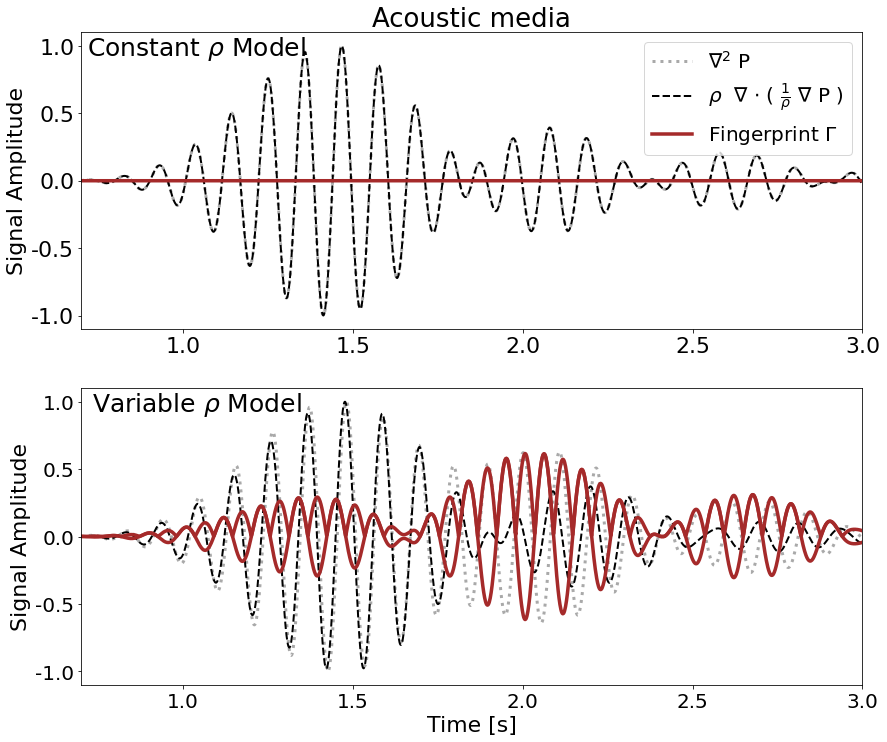

In [74]:
import matplotlib.ticker as ticker
posX=12
posY=12
time_vec = np.linspace(2*dt_sub,(nt_sub*dt_sub)-(2*dt_sub),nt_sub-4)
time_vec2 = np.linspace(2*dt_sub2,(nt_sub2*dt_sub2)-(2*dt_sub2),nt_sub2-4)

fig, (ax1,ax2) = plt.subplots(figsize=(14,12),nrows=2, gridspec_kw={'height_ratios': [1,1]})
#plt.suptitle('Acoustic media', fontsize=28)
#ax1.set_title(r'$\mathbf{Acoustic \: media}$ '+ "\n \n" +r'Spatial Gradients - Constant $\rho$ Model', fontsize=24)
ax1.set_title('Acoustic media', fontsize=26)

ax1.plot(time_vec2,U_LAPLACE_CST2_true[posX,posY,1:-1]/np.max(U_LAPLACE_CST2_true[posX,posY,1:-1]), linewidth= 3, color='darkgrey',linestyle=':',label=r'$\nabla^{2}$ P')
#ax1.plot(time_vec2, rhs_BASE[posX,posY,:])
#ax1.plot(U_LAPLACE_CST_true[posX,posY,:], linewidth= 3, color='blue',label=r'[ $\nabla^{2}$ u]')
#ax1.plot(rhs_BASE[posX,posY,:]-U_LAPLACE_CST2_true[posX,posY,:],label='Misfit')


ax1.plot(time_vec2,U_LAPLACE_VAR_true2[posX,posY,1:-1]/np.max(U_LAPLACE_VAR_true2[posX,posY,1:-1]), linewidth= 2, color='black',linestyle='--',label=r'$\rho$  $\nabla$ $\cdot$ ( $\frac{1}{\rho}$ $\nabla$ P )')
#ax1.plot(time_vec2,(U_LAPLACE_VAR_true2[posX,posY,1:-1]/np.max(U_LAPLACE_VAR_true2[posX,posY,1:-1]))-(U_LAPLACE_CST2_true[posX,posY,1:-1]/np.max(U_LAPLACE_CST2_true[posX,posY,1:-1])), linestyle='-', linewidth= 3.5, color='brown' , label=r'$\frac{\Delta\rho}{\rho}$ Fingerprint $\Gamma$')
ax1.plot(time_vec2,(U_LAPLACE_VAR_true2[posX,posY,1:-1]/np.max(U_LAPLACE_VAR_true2[posX,posY,1:-1]))-(U_LAPLACE_CST2_true[posX,posY,1:-1]/np.max(U_LAPLACE_CST2_true[posX,posY,1:-1])), linestyle='-', linewidth= 3.5, color='brown' , label=r'Fingerprint $\Gamma$')

#ax1.set_ylim([1.1*np.min(U_LAPLACE_CST_true[posX,posY,:]),1.1*np.max(U_LAPLACE_CST_true[posX,posY,:])])

#ax2.set_title(r'Variable $\rho$ Model', fontsize=24)
ax2.plot(time_vec,U_LAPLACE_CST_true[posX,posY,1:-1]/np.max(U_LAPLACE_CST_true[posX,posY,1:-1]), linewidth= 3, color='darkgrey',linestyle=':',label=r'$\nabla^{2}$ P')
ax2.plot(time_vec,U_LAPLACE_VAR_true[posX,posY,1:-1]/np.max(U_LAPLACE_VAR_true[posX,posY,1:-1]), linewidth= 2, color='black' , linestyle='--',label=r'$\rho$  $\nabla$ $\cdot$ ( $\frac{1}{\rho}$ $\nabla$ P )')
ax2.plot(time_vec,abs((U_LAPLACE_VAR_true[posX,posY,1:-1]/np.max(U_LAPLACE_VAR_true[posX,posY,1:-1]))-(U_LAPLACE_CST_true[posX,posY,1:-1]/np.max(U_LAPLACE_CST_true[posX,posY,1:-1]))), linestyle='-', linewidth= 3.5, color='brown' , label=r'Fingerprint $\Gamma$')
ax2.plot(time_vec,((U_LAPLACE_VAR_true[posX,posY,1:-1]/np.max(U_LAPLACE_VAR_true[posX,posY,1:-1]))-(U_LAPLACE_CST_true[posX,posY,1:-1]/np.max(U_LAPLACE_CST_true[posX,posY,1:-1]))), linestyle='-', linewidth= 3.5, color='brown' , label=r'Fingerprint $\Gamma$')

#ax2.plot(time_vec,rhs[posX,posY,:,0], linewidth= 3, label=r'$\frac{1}{(c_{w})^{2}}$ $\delta_{t}^{2}$ P',linestyle=':', color='deepskyblue')
#ax2.plot(time_vec,rhs_helm[posX,posY,:,0], linewidth= 3, label=r'$\frac{1}{(c_{w})^{2}}$ $\delta_{t}^{2}$ P',linestyle=':', color='yellow')
#ax2.set_ylim([1.1*np.min(U_LAPLACE_CST_true[posX,posY,:]),1.1*np.max(U_LAPLACE_CST_true[posX,posY,:])])
#ax2.plot(time_vec,Utt_LAPLACE_CST_true[posX,posY,:], linewidth= 3, color='black',label=r'[ $\nabla^{2}$ P]')


#ax2.plot(-U_LAPLACE_VAR_true[posX,posY,:]+U_LAPLACE_VAR_true2[posX,posY,:], linestyle='-',linewidth= 2, color='yellow', label='Density Signal')
#ax2.plot(-U_LAPLACE_CST_true[posX,posY,:]+U_LAPLACE_CST2_true[posX,posY,:], linestyle='-',linewidth= 2, color='yellow', label='Density Signal')

#ax2.plot(time_vec,U_LAPLACE_VAR_true[posX,posY,:]-U_LAPLACE_CST_true[posX,posY,:], linestyle='-', linewidth= 4, color='black' , label='Density Signal')
#ax2.plot(time_vec,U_LAPLACE_VAR_true2[posX,posY,:]-U_LAPLACE_VAR_true[posX,posY,:], linestyle='-', linewidth= 4, color='black' , label='Density Signal')

#ax2.set_xlabel('Time [s]',fontsize=16)
ax2.set_ylabel('Signal Amplitude',fontsize=22)
ax1.set_ylabel('Signal Amplitude',fontsize=22)

ax1.set_xlim([dt_sub,3-dt_sub])
ax1.xaxis.set_tick_params(labelsize=22)
ax1.yaxis.set_tick_params(labelsize=22)
ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
ax1.legend(fontsize=20, loc='upper right')

ax2.set_xlim([dt_sub,3-dt_sub])
ax2.xaxis.set_tick_params(labelsize=20)
ax2.yaxis.set_tick_params(labelsize=20)
ax2.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
#ax2.legend(fontsize=20, ncol=1, loc='upper right')
ax2.set_xlabel('Time [s]',fontsize=22)

ax1.set_xlim([0.2,2.8])
ax2.set_xlim([0.2,2.8])

ax1.set_xlim([0.7,3])
ax2.set_xlim([0.7,3])

ax1.set_xlim([0.7,3])
ax2.set_xlim([0.7,3])

ax1.text(1.04, 0.98, r'Constant $\rho$ Model', size=25, rotation=0.,
         ha="center", va="center",
#          bbox=dict(boxstyle="round",
#                    ec=(1., 0.5, 0.5),
#                    fc=(1., 0.8, 0.8),
#                    )
         )

ax2.text(1.04, 0.98, r'Variable $\rho$ Model', size=25, rotation=0.,
         ha="center", va="center",)
# ax1.set_xlim([0.25,1.5])
# ax2.set_xlim([0.25,1.5])
# ax3.set_xlim([0.25,1.5])
#ax2.set_ylim([-3e-07,3e-07])

In [ ]:
(1/U_LAPLACE_CST_true[posX,posY,1:-1].shape[0])*abs((U_LAPLACE_VAR_true[posX,posY,1:-1]/np.max(U_LAPLACE_VAR_true[posX,posY,1:-1]))-(U_LAPLACE_CST_true[posX,posY,1:-1]/np.max(U_LAPLACE_CST_true[posX,posY,1:-1]))).sum()

In [ ]:
grid_signal = np.zeros((nr,nr))
for i in range(0,nr):
    for j in range(0,nr):
        grid_signal[i,j] = (1/U_LAPLACE_CST_true[i,j,1:-1].shape[0])*abs((U_LAPLACE_VAR_true[i,j,1:-1]/np.max(U_LAPLACE_VAR_true[i,j,1:-1]))-(U_LAPLACE_CST_true[i,j,1:-1]/np.max(U_LAPLACE_CST_true[i,j,1:-1]))).sum(0)
print(np.mean(grid_signal))
plt.imshow(100*grid_signal[1:-1,1:-1])
plt.colorbar()
grid_signal[posX,posY]
print(np.mean(grid_signal))

In [ ]:
ratio = np.asarray(np.gradient(rho_grad)).sum(0)/rho_grad
plt.imshow(ratio[:,:,0])
plt.colorbar()

In [ ]:
rho_GRAD_X_true  = np.empty((nr, nr,nrz))
rho_GRAD_Y_true  = np.empty((nr, nr,nrz))
for l in range(1,nr-1):
                rho_GRAD_X_true[l, :] = (rho_grad[l+1,:,:] - rho_grad[l-1,:,:])/(dist_r*2)
for k in range(1,nr-1):
                rho_GRAD_Y_true[:,k] = (rho_grad[:,k+1,:] -  rho_grad[:,k-1,:])/(dist_r*2)
rho_GRAD_true = rho_GRAD_X_true + rho_GRAD_Y_true

In [ ]:
plt.imshow(rho_GRAD_true[1:-1,1:-1,0])
plt.colorbar()

In [ ]:
plt.plot(rho_GRAD_true[1:-1,1:-1,0].sum(1))

In [ ]:
posX=12
posY=12
# lhs_ = U_LAPLACE_CST_true[posX,posY,1:-1] - ((1/(c_sub[posX,posY,0]**2))*Utt_LAPLACE_CST_true[posX,posY,1:-1])
# lhs_2 = U_LAPLACE_CST_true[posX,posY,1:-1] - ((1/(c_phase_Z_2D_CST[posX,posY,0,0]**2))*Utt_LAPLACE_CST_true[posX,posY,1:-1])
lhs_ = U_LAPLACE_CST_true[:,:,1:-1] - ((1/(c_sub[:,:,0,np.newaxis,np.newaxis]**2))*Utt_LAPLACE_CST_true[:,:,1:-1])
lhs_2 = U_LAPLACE_CST_true[:,:,1:-1] - ((1/(c_phase_Z_2D_CST[:,:,0,0,np.newaxis,np.newaxis]**2))*Utt_LAPLACE_CST_true[:,:,1:-1])

# plt.figure(figsize=(10,8))
# #plt.plot(time_vec,lhs_, linestyle='--', linewidth= 1.5, color='springgreen' )

# plt.plot(time_vec,lhs_2, linestyle='--', linewidth= 1.5, color='magenta' )
# plt.plot(time_vec,-DIVxy[posX,posY,0,2:-2], linestyle='-', linewidth= 3.5, color='brown' , label='Density Signal')


In [ ]:
dxrho = rho_GRAD_X_true#np.asarray(np.gradient(rho_grad))[0]
dyrho = rho_GRAD_Y_true#np.asarray(np.gradient(rho_grad))[1]
dxP = VEL_Z_gradX 
dyP = VEL_Z_gradY

DIVxy = -(1/rho_grad[:,:,:,np.newaxis,np.newaxis]) * ((dxrho[:,:,:,np.newaxis,np.newaxis]*dxP) + (dyrho[:,:,:,np.newaxis,np.newaxis]*dyP))
DIVy = -(1/rho_grad[:,:,:,np.newaxis,np.newaxis]) *  (dxrho[:,:,:,np.newaxis,np.newaxis]*dxP)
DELTA = (U_LAPLACE_VAR_true[:,:,:]-U_LAPLACE_CST_true[:,:,:])

signal = np.divide(abs(DELTA[:,:,2:-2,0]).sum(2), abs(dxP[:,:,0,2:-2,0]).sum(2))
signal2 = np.divide(abs(lhs_2[:,:,2:-2,0]).sum(2), abs(dxP[:,:,0,2:-2,0]).sum(2))

In [ ]:
plt.imshow(abs(dxrho[1:-1,1:-1,0]/rho_grad[1:-1,1:-1,0]))
plt.colorbar()

In [ ]:
plt.plot(-dxP[posX,posY,0,4:-4,0], DELTA[posX,posY,3:-3,0])

In [ ]:
nt_range = nt_sub-2
comp = 'Z'
ratioRHO, mZ_2D, r_sq_Z_2D = LinReg_c(-dxP[:,:,0,2:-2,0], DELTA[:,:,1:-1,0],nt_range-2, ll, nr**2, nr, nr, 1,ordd)

In [ ]:
plt.imshow(ratioRHO[1:-1,1:-1,0,0])
plt.colorbar()

In [ ]:
nt_range = nt_sub-2
comp = 'Z'
ratioRHO2, mZ_2D, r_sq_Z_2D = LinReg_c(-dxP[:,:,0,4:-4,0], lhs_2[:,:,2:-2,0],nt_range-6, ll, nr**2, nr, nr, 1,ordd)

In [ ]:
plt.plot(ratioRHO[1:-1,1:-1,0,0].sum(1)/18)
plt.plot(ratioRHO2[1:-1,1:-1,0,0].sum(1)/18)

In [ ]:
plt.plot(abs(dxrho[1:-1,1:-1,0]/rho_grad[1:-1,1:-1,0]).sum(1)/18)
plt.plot(signal[1:-1,1:-1].sum(1)/18)
#plt.plot(ratioRHO[1:-1,1:-1,0,0].sum(1)/18)
#plt.plot(signal2[1:-1,1:-1].sum(1)/18)

In [ ]:
plt.imshow(signal[1:-1,1:-1])
plt.colorbar()

In [ ]:
plt.imshow(signal2[1:-1,1:-1])
plt.colorbar()

In [ ]:
plt.plot(abs(dxrho[1:-1,1:-1,0]/rho_grad[1:-1,1:-1,0]).sum(1)/18)
plt.plot(signal2[1:-1,1:-1].sum(1)/18)

In [ ]:
plt.plot(divP[posX,posY,0,2:-2])

In [ ]:
testtt =  - ratio[:,:,:,np.newaxis,np.newaxis] * divP
plt.plot(testtt[posX,posY,0,2:-2])
plt.plot(DIVxy[posX,posY,0,2:-2])

In [ ]:
posX=12
posY=12
delta = (U_LAPLACE_VAR_true[posX,posY,1:-1]-U_LAPLACE_CST_true[posX,posY,1:-1])
plt.figure(figsize=(10,8))
plt.plot(time_vec,DIVxy[posX,posY,0,2:-2], linestyle='-', linewidth= 4.5, color='brown' , label='Density Signal')
plt.plot(time_vec,DIVy[posX,posY,0,2:-2], linestyle='-', linewidth= 1.5, color='springgreen' )
plt.plot(time_vec,delta, linestyle='--', linewidth= 1.5, color='yellow' )


In [ ]:
plt.plot(time_vec,-dxP[posX,posY,0,2:-2], linestyle='-', linewidth= 1.5, color='springgreen' )


In [ ]:
plt.plot(DIVxy[posX,posY,0,2:-2], delta)

In [ ]:
posX=12
posY=12
plt.figure(figsize=(10,8))
delta = (U_LAPLACE_VAR_true[posX,posY,1:-1]-U_LAPLACE_CST_true[posX,posY,1:-1])
plt.plot(time_vec,np.divide((delta),(dxP[posX,posY,0,2:-2])), linestyle='-', linewidth= 3.5, color='brown' , label='Density Signal')
#plt.plot(time_vec,dxP[posX,posY,0,2:-2], linestyle='-', linewidth= 3.5, color='brown' , label='Density Signal')
#plt.plot(time_vec,delta, linestyle='-', linewidth= 3.5, color='brown' , label='Density Signal')


In [ ]:
delta = U_LAPLACE_VAR_true[:,:,1:-1]-U_LAPLACE_CST_true[:,:,1:-1]
delta.shape
np.reshape(delta,(20,20,1,nt_sub,1)).shape

In [ ]:
#divP.shape

In [ ]:
plt.plot(delta[2,2])
plt.plot(divP[2,2,0])

In [ ]:
divP[:,:,:,2:-2].shape
testR = np.reshape(divP[:,:,0,2:-2],(20,20,1,938,1))
testR.shape
testL = np.reshape(delta,(20,20,1,938,1))

In [ ]:
plt.plot(testL[4,5,0,2:-2,0], testR[4,5,0,2:-2,0])

In [ ]:
nt_range = nt_sub-2
comp = 'Z'
ratioRHO, mZ_2D, r_sq_Z_2D = LinReg_c(testR, testL, nt_range-2, ll, 20**2, 20, 20, 1,ordd)

In [ ]:
plt.plot(ratioRHO[1:-1,1:-1,0,0].sum(1))

In [ ]:
plt.imshow(ratioRHO[1:-1,1:-1,0,0]*rho_grad[1:-1,1:-1,0])
plt.colorbar()

In [ ]:
plt.imshow((U_LAPLACE_VAR_true[1:-1,1:-1,1:-1]-U_LAPLACE_CST_true[1:-1,1:-1,1:-1]).sum(2))
plt.colorbar()

In [ ]:
break

In [ ]:
import matplotlib.ticker as ticker
posX=12
posY=12
time_vec = np.linspace(dt_sub,3-dt_sub,nt_sub-2)
time_vec2 = np.linspace(dt_sub2,3-dt_sub2,nt_sub2-2)

fig, (ax1,ax2,ax3) = plt.subplots(figsize=(15,18),nrows=3, gridspec_kw={'height_ratios': [1,1,1]})
ax1.set_title(r'Spatial Gradients - Constant $\rho$ Model', fontsize=20)
ax1.plot(time_vec2,U_LAPLACE_CST2_true[posX,posY,:], linewidth= 3, color='darkgrey',linestyle='--',label=r'[ $\nabla^{2}$ P]')
#ax1.plot(time_vec2, rhs_BASE[posX,posY,:])
#ax1.plot(U_LAPLACE_CST_true[posX,posY,:], linewidth= 3, color='blue',label=r'[ $\nabla^{2}$ u]')
#ax1.plot(rhs_BASE[posX,posY,:]-U_LAPLACE_CST2_true[posX,posY,:],label='Misfit')


ax1.plot(time_vec2,U_LAPLACE_VAR_true2[posX,posY,:], linewidth= 2, color='tab:blue',linestyle=':',label=r'$\rho$ [ $\nabla$ $\frac{1}{\rho}$ $\nabla$ P]')
ax1.plot(time_vec2,U_LAPLACE_VAR_true2[posX,posY,:]-U_LAPLACE_CST2_true[posX,posY,:], linestyle='-', linewidth= 4, color='black' , label='Density Signal')
ax1.set_ylim([1.1*np.min(U_LAPLACE_CST_true[posX,posY,:]),1.1*np.max(U_LAPLACE_CST_true[posX,posY,:])])

ax2.set_title(r'Spatial Gradients - Variable $\rho$ Model', fontsize=20)
ax2.plot(time_vec,U_LAPLACE_CST_true[posX,posY,:], linewidth= 3, color='darkgrey',linestyle='--',label=r'[ $\nabla^{2}$ P]')
ax2.plot(time_vec,U_LAPLACE_VAR_true[posX,posY,:], linewidth= 2, color='tab:blue' , linestyle=':',label=r'$\rho$ [ $\nabla$ $\frac{1}{\rho}$ $\nabla$ P]')

#ax2.plot(time_vec,rhs[posX,posY,:,0], linewidth= 3, label=r'$\frac{1}{(c_{w})^{2}}$ $\delta_{t}^{2}$ P',linestyle=':', color='deepskyblue')
#ax2.plot(time_vec,rhs_helm[posX,posY,:,0], linewidth= 3, label=r'$\frac{1}{(c_{w})^{2}}$ $\delta_{t}^{2}$ P',linestyle=':', color='yellow')
#ax2.set_ylim([1.1*np.min(U_LAPLACE_CST_true[posX,posY,:]),1.1*np.max(U_LAPLACE_CST_true[posX,posY,:])])
#ax2.plot(time_vec,Utt_LAPLACE_CST_true[posX,posY,:], linewidth= 3, color='black',label=r'[ $\nabla^{2}$ P]')


#ax2.plot(-U_LAPLACE_VAR_true[posX,posY,:]+U_LAPLACE_VAR_true2[posX,posY,:], linestyle='-',linewidth= 2, color='yellow', label='Density Signal')
#ax2.plot(-U_LAPLACE_CST_true[posX,posY,:]+U_LAPLACE_CST2_true[posX,posY,:], linestyle='-',linewidth= 2, color='yellow', label='Density Signal')
sig= (U_LAPLACE_VAR_true[posX,posY,:]-U_LAPLACE_CST_true[posX,posY,:])
ax2.plot(time_vec,sig, linestyle='-', linewidth= 4, color='black' , label='Density Signal')
#ax2.plot(time_vec,U_LAPLACE_VAR_true2[posX,posY,:]-U_LAPLACE_VAR_true[posX,posY,:], linestyle='-', linewidth= 4, color='black' , label='Density Signal')
sig_diff = U_LAPLACE_VAR_true2[posX,posY,:]-U_LAPLACE_VAR_true[posX,posY,:]
ax2.plot(time_vec2,sig_diff, linestyle='-', linewidth= 4, color='yellow' , label='Difference')

#ax2.set_xlabel('Time [s]',fontsize=16)
ax2.set_ylabel('Signal Amplitude',fontsize=20)
ax1.set_ylabel('Signal Amplitude',fontsize=20)

ax1.set_xlim([dt_sub,3-dt_sub])
ax1.xaxis.set_tick_params(labelsize=18)
ax1.yaxis.set_tick_params(labelsize=18)
ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1e'))
ax1.legend(fontsize=18, loc='upper right')

ax2.set_xlim([dt_sub,3-dt_sub])
ax2.xaxis.set_tick_params(labelsize=18)
ax2.yaxis.set_tick_params(labelsize=18)
ax2.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1e'))
ax2.legend(fontsize=18, ncol=1, loc='upper right')

ax3.set_title(r'Spatial Gradients - Difference between Constant & Variable $\rho$ Model', fontsize=20)
ax3.plot(time_vec2,U_LAPLACE_VAR_true2[posX,posY,:], linewidth= 3, color='darkgrey',linestyle='--',label=r'$\rho$ [ $\nabla$ $\frac{1}{\rho}$ $\nabla$ $P]_{cst}$')
ax3.plot(time_vec,U_LAPLACE_VAR_true[posX,posY,:], linewidth= 2, color='tab:blue',linestyle=':',label=r'$\rho$ [ $\nabla$ $\frac{1}{\rho}$ $\nabla$ $P]_{var}$')
ax3.plot(time_vec2,U_LAPLACE_VAR_true2[posX,posY,:]-U_LAPLACE_VAR_true[posX,posY,:], linestyle='-', linewidth= 4, color='black' , label='Difference')

#ax3.plot(time_vec2,Utt_LAPLACE_CST2_true[posX,posY,:], linewidth= 3, color='darkgrey',linestyle='--', label = r'$(\delta_{t}^{2} P_{cst})$')
#ax3.plot(time_vec,Utt_LAPLACE_CST_true[posX,posY,:], linewidth= 2, color='tab:blue' , linestyle=':',label = r'$(\delta_{t}^{2} P_{var})$')
#ax3.plot(time_vec2,Utt_LAPLACE_CST2_true[posX,posY,:]-Utt_LAPLACE_CST_true[posX,posY,:], linewidth= 4, color='black' , linestyle='-', label = r'$\Delta (\delta_{t}^{2} P)$')

#ax3.plot(time_vec,Utt_LAPLACE_VAR_true2[posX,posY,:], linewidth= 3, color='darkgrey',linestyle='--', label = r'$(\delta_{t}^{2} P_{cst})$')
#ax3.plot(time_vec,Utt_LAPLACE_VAR_true[posX,posY,:], linewidth= 2, color='tab:blue' , linestyle=':',label = r'$(\delta_{t}^{2} P_{var})$')

#ax3.plot(time_vec2,Utt_LAPLACE_CST2_true[posX,posY,:]-Utt_LAPLACE_CST_true[posX,posY,:], linewidth= 4, color='black' , linestyle='-', label = r'$\Delta (\delta_{t}^{2} P)$')
#ax3.plot(time_vec,Utt_LAPLACE_VAR_true2[posX,posY,:]-Utt_LAPLACE_VAR_true[posX,posY,:], linewidth= 2, color='lime' , linestyle='-', label = r'$\Delta (\delta_{t}^{2} P)$')

ax3.set_xlim([dt_sub,3-dt_sub])
ax3.xaxis.set_tick_params(labelsize=18)
ax3.yaxis.set_tick_params(labelsize=18)
ax3.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1e'))
ax3.legend(fontsize=18, ncol=1, loc='upper right')
ax3.set_xlabel('Time [s]',fontsize=20)
ax3.set_ylabel('Signal Amplitude',fontsize=20)

ax1.set_xlim([0.25,3])
ax2.set_xlim([0.25,3])
ax3.set_xlim([0.25,3])
# ax1.set_xlim([0.3,1.0])
# ax2.set_xlim([0.3,1.0])
# ax3.set_xlim([0.3,1.0])

In [ ]:
np.gradient(sig[:,0]).shape

In [ ]:
if medium=='acoustic':
    plt.figure(figsize=(10,8))
    plt.plot(time_vec[:],U_LAPLACE_CST_true[posX,posY,:], linewidth= 3, color='darkgrey',linestyle='--',label=r'[ $\nabla^{2}$ P]')
    plt.plot(time_vec[:],U_LAPLACE_VAR_true[posX,posY,:], linewidth= 2, color='tab:blue' , linestyle=':',label=r'$\rho$ [ $\nabla$ $\frac{1}{\rho}$ $\nabla$ P]')
    plt.plot(time_vec[:],U_LAPLACE_CST_true[posX,posY,:]-U_LAPLACE_VAR_true[posX,posY,:], linestyle='-', linewidth= 4, color='black' , label='Density Signal')

elif medium=='elastic':
    plt.figure(figsize=(10,8))
    plt.plot(time_vec[:],U_LAPLACE_CST_true[posX,posY,:], linewidth= 3, color='darkgrey',linestyle='--',label=r'[ $\nabla^{2}$ P]')
    plt.plot(time_vec[:],U_LAPLACE_VAR_true[posX,posY,:], linewidth= 2, color='tab:blue' , linestyle=':',label=r'$\rho$ [ $\nabla$ $\frac{1}{\rho}$ $\nabla$ P]')
    plt.plot(time_vec[:],U_LAPLACE_CST_true[posX,posY,:]-U_LAPLACE_VAR_true[posX,posY,:], linestyle='-', linewidth= 4, color='black' , label='Density Signal')
plt.xlim([1.2,2.3])
plt.ylim([-0.6e-7,0.6e-7])

In [ ]:
break

In [ ]:
break

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(time_vec,U_LAPLACE_CST2_true[posX,posY,:], linestyle='-', linewidth= 2, color='crimson' , label='Difference')
plt.plot(time_vec,U_LAPLACE_VAR_true2[posX,posY,:], linestyle='-', linewidth= 2, color='black' , label='Difference')
plt.plot(time_vec,(1/c_inv[posX,posY]**2)*Utt_LAPLACE_CST2_true[posX,posY,:], linewidth= 2, color='lime' , linestyle='-', label = r'$\Delta (\delta_{t}^{2} P)$')


In [ ]:
plt.figure(figsize=(10,8))
plt.plot(time_vec,U_LAPLACE_CST_true[posX,posY,:], linestyle='-', linewidth= 2, color='crimson' , label='Difference')
plt.plot(time_vec,U_LAPLACE_VAR_true[posX,posY,:], linestyle='-', linewidth= 2, color='black' , label='Difference')
plt.plot(time_vec,(1/c_inv[posX,posY]**2)*Utt_LAPLACE_CST_true[posX,posY,:], linewidth= 2, color='lime' , linestyle='-', label = r'$\Delta (\delta_{t}^{2} P)$')


In [ ]:
import matplotlib.ticker as ticker
posX=12
posY=12
time_vec = np.linspace(dt_sub,3-dt_sub,nt_sub-2)
time_vec2 = np.linspace(dt_sub2,3-dt_sub2,nt_sub2-2)

fig, (ax1,ax3) = plt.subplots(figsize=(15,12),nrows=2, gridspec_kw={'height_ratios': [1,1]})
ax1.set_title(r'Spatial Gradients - Difference between Constant & Variable $\rho$ Model', fontsize=20)
ax1.plot(time_vec2,U_LAPLACE_VAR_true2[posX,posY,:], linewidth= 3, color='darkgrey',linestyle='--',label=r'$\rho$ [ $\nabla$ $\frac{1}{\rho}$ $\nabla$ $P]_{cst}$')
ax1.plot(time_vec2,U_LAPLACE_VAR_true[posX,posY,:], linewidth= 2, color='tab:blue',linestyle=':',label=r'$\rho$ [ $\nabla$ $\frac{1}{\rho}$ $\nabla$ $P]_{var}$')

ax1.plot(time_vec,U_LAPLACE_VAR_true2[posX,posY,:]-U_LAPLACE_VAR_true[posX,posY,:], linestyle='-', linewidth= 4, color='black' , label='Difference')
#ax1.plot(time_vec,U_LAPLACE_CST2_true[posX,posY,:]-U_LAPLACE_CST_true[posX,posY,:], linestyle='-', linewidth= 4, color='black' , label='Difference')

#ax1.set_ylim([1.1*np.min(U_LAPLACE_CST_true[posX,posY,:]),1.1*np.max(U_LAPLACE_CST_true[posX,posY,:])])

ax1.set_ylabel('Signal Amplitude',fontsize=20)
ax1.set_xlim([dt_sub,3-dt_sub])
ax1.xaxis.set_tick_params(labelsize=18)
ax1.yaxis.set_tick_params(labelsize=18)
ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1e'))
ax1.legend(fontsize=18, loc='upper right')


ax3.set_title(r'Temporal Gradients - Difference between Constant & Variable $\rho$ Model', fontsize=20)
ax3.plot(time_vec,Utt_LAPLACE_CST2_true[posX,posY,:], linewidth= 3, color='darkgrey',linestyle='--', label = r'$(\delta_{t}^{2} P_{cst})$')
ax3.plot(time_vec,Utt_LAPLACE_CST_true[posX,posY,:], linewidth= 2, color='tab:blue' , linestyle=':',label = r'$(\delta_{t}^{2} P_{var})$')
ax3.plot(time_vec,Utt_LAPLACE_CST2_true[posX,posY,:]-Utt_LAPLACE_CST_true[posX,posY,:], linewidth= 4, color='black' , linestyle='-', label = r'$\Delta (\delta_{t}^{2} P)$')

ax3.set_xlim([dt_sub,3-dt_sub])
ax3.xaxis.set_tick_params(labelsize=18)
ax3.yaxis.set_tick_params(labelsize=18)
ax3.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1e'))
ax3.legend(fontsize=18, ncol=1, loc='upper right')
ax3.set_xlabel('Time [s]',fontsize=20)
ax3.set_ylabel('Signal Amplitude',fontsize=20)





In [ ]:
plt.figure(figsize=(10,8))
plt.plot(time_vec,(1/c_inv[posX,posY])**2 *Utt_LAPLACE_CST_true[posX,posY,:], linewidth= 2, color='tab:orange' , linestyle='-',label = r'$(\delta_{t}^{2} P_{var})$')

plt.plot(time_vec2,U_LAPLACE_VAR_true[posX,posY,:], linewidth= 2, color='tab:blue',linestyle=':',label=r'$\rho$ [ $\nabla$ $\frac{1}{\rho}$ $\nabla$ $P]_{var}$')
plt.plot(time_vec2,U_LAPLACE_CST_true[posX,posY,:], linewidth= 2, color='crimson',linestyle='--',label=r'$\rho$ [ $\nabla$ $\frac{1}{\rho}$ $\nabla$ $P]_{var}$')


In [ ]:
plt.scatter(U_LAPLACE_VAR_true[posX,posY,:],Utt_LAPLACE_VAR_true[posX,posY,:])
#plt.scatter(U_LAPLACE_CST_true[posX,posY,:],Utt_LAPLACE_CST_true[posX,posY,:])


In [ ]:
# plt.figure(figsize=(16,10))
# plt.plot(time_vec,U_LAPLACE_CST_true[posX,posY,:], linewidth= 3, color='darkgrey',linestyle='--',label=r'[ $\nabla^{2}$ P]')
# plt.plot(time_vec,U_LAPLACE_VAR_true[posX,posY,:], linewidth= 2, color='tab:blue' , linestyle=':',label=r'$\rho$ [ $\nabla$ $\frac{1}{\rho}$ $\nabla$ P]')
# plt.plot(time_vec,rhs_VAR[posX,posY,:], linewidth= 3, color='lime',linestyle='--', label = r'$(\delta_{t}^{2} P_{cst})$')


In [ ]:
rho_signal = (U_LAPLACE_VAR_true[1:-1,1:-1,1:-1]-U_LAPLACE_CST_true[1:-1,1:-1,1:-1]).sum(0).sum(0)/(nr-2)**2
#rho_signal_sum = (U_LAPLACE_VAR_true[posX,posY,1:-1]-U_LAPLACE_CST_true[posX,posY,1:-1]).sum()/nt_sub


In [ ]:
plt.plot( (U_LAPLACE_VAR_true[5,5]-U_LAPLACE_CST_true[5,5]))
plt.plot( (U_LAPLACE_VAR_true[15,15]-U_LAPLACE_CST_true[15,15]))

plt.plot(rho_signal)

In [ ]:
rho_signal = (U_LAPLACE_VAR_true[1:-1,1:-1,1:-1]-U_LAPLACE_CST_true[1:-1,1:-1,1:-1]).sum(0).sum(0)/(nr-2)**2

to_export = pd.DataFrame(rho_signal)
to_export.to_csv(fig_+'/rho_signal'+'_'+str(round(f_filt_cent[0])), index=False)

to_export = pd.DataFrame(U_LAPLACE_VAR_true[posX,posY,1:-1])
to_export.to_csv(fig_+'/UspVAR'+'_'+str(round(f_filt_cent[0])), index=False)

In [ ]:
break

In [ ]:
RHO_SIGNAL_RATIO = np.zeros((18,1))
fff = np.array([3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
i=0
for ff in fff: 
    RHO_SIGNAL_RATIO[i,:] = (abs(pd.read_csv(fig_+'/rho_signal'+'_'+str(ff))).values.sum(0)/nt_sub) / (abs(pd.read_csv(fig_+'/UspVAR'+'_'+str(ff))).values.sum(0)/nt_sub)
    i=i+1

In [ ]:
plt.figure(figsize=(10,8))
plt.scatter(100*RHO_SIGNAL_RATIO,fff)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Density Signal Strength [%]')


In [ ]:
plt.scatter(Pxx/np.max(Pxx),fff2)
plt.ylim(0,30)


In [ ]:
## data vector actually changes from constant to variable density model
fig, ax = plt.subplots(figsize=(8,5))

#plt.plot(time_vec,Utt_LAPLACE_CST2_true[posX,posY,:], linewidth= 4, color='black' , linestyle='--')
#plt.plot(time_vec,Utt_LAPLACE_CST2_true[1:-1,1:-1,:].sum(0).sum(0)/(18**2)-Utt_LAPLACE_CST_true[1:-1,1:-1,:].sum(0).sum(0)/(18**2), linewidth= 2, color='lime' , linestyle='-', label = r'$\Delta (\delta_{t}^{2} P)$')
plt.plot(time_vec,Utt_LAPLACE_CST2_true[posX,posY,:]-Utt_LAPLACE_CST_true[posX,posY,:], linewidth= 2, color='lime' , linestyle='-', label = r'$\Delta (\delta_{t}^{2} P)$')
#ax2.plot(time_vec,Utt_LAPLACE_CST2_true[posX,posY,:], linewidth= 4, color='yellow' , linestyle='--')
#ax2.plot(time_vec,Utt_LAPLACE_CST_true[posX,posY,:], linewidth= 4, color='green' , linestyle='--')
#ax2.plot(time_vec,Utt_LAPLACE_VAR_true[posX,posY,:], linewidth= 4, color='darkblue' , linestyle='--')
ax.set_xlim([dt_sub,3-dt_sub])
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1e'))
ax.legend(fontsize=16, ncol=2)
ax.set_xlabel('Time [s]',fontsize=16)
ax.set_ylabel('Signal Amplitude',fontsize=16)

In [ ]:
import matplotlib.ticker as ticker
posX=12
posY=12
time_vec = np.linspace(dt_sub,3-dt_sub,nt_sub-2)
time_vec2 = np.linspace(dt_sub2,3-dt_sub2,nt_sub2-2)

fig, (ax1,ax2) = plt.subplots(figsize=(14,12),nrows=2)
ax1.set_title(r'Constant $\rho$ Model', fontsize=20)
ax1.plot(time_vec2,U_LAPLACE_CST2_true[posX,posY,:], linewidth= 3, color='black',label=r'[ $\nabla^{2}$ P]')
ax1.plot(time_vec2, rhs_BASE[posX,posY,:])
#ax1.plot(U_LAPLACE_CST_true[posX,posY,:], linewidth= 3, color='blue',label=r'[ $\nabla^{2}$ u]')
#ax1.plot(rhs_BASE[posX,posY,:]-U_LAPLACE_CST2_true[posX,posY,:],label='Misfit')


ax1.plot(time_vec2,U_LAPLACE_VAR_true2[posX,posY,:], linewidth= 4, color='darkgrey',linestyle=':',label=r'$\rho$ [ $\nabla$ $\frac{1}{\rho}$ $\nabla$ P]')
ax1.set_ylim([1.1*np.min(U_LAPLACE_CST_true[posX,posY,:]),1.1*np.max(U_LAPLACE_CST_true[posX,posY,:])])

ax2.set_title(r'Variable $\rho$ Model', fontsize=20)
ax2.plot(time_vec,U_LAPLACE_CST_true[posX,posY,:], linewidth= 3, color='black',label=r'[ $\nabla^{2}$ P]')
ax2.plot(time_vec,U_LAPLACE_VAR_true[posX,posY,:], linewidth= 4, color='darkgrey' , linestyle='--',label=r'$\rho$ [ $\nabla$ $\frac{1}{\rho}$ $\nabla$ P]')

#ax2.plot(time_vec,rhs[posX,posY,:,0], linewidth= 3, label=r'$\frac{1}{(c_{w})^{2}}$ $\delta_{t}^{2}$ P',linestyle=':', color='deepskyblue')
#ax2.plot(time_vec,rhs_helm[posX,posY,:,0], linewidth= 3, label=r'$\frac{1}{(c_{w})^{2}}$ $\delta_{t}^{2}$ P',linestyle=':', color='yellow')
#ax2.set_ylim([1.1*np.min(U_LAPLACE_CST_true[posX,posY,:]),1.1*np.max(U_LAPLACE_CST_true[posX,posY,:])])
#ax2.plot(time_vec,Utt_LAPLACE_CST_true[posX,posY,:], linewidth= 3, color='black',label=r'[ $\nabla^{2}$ P]')


#ax2.plot(-U_LAPLACE_VAR_true[posX,posY,:]+U_LAPLACE_VAR_true2[posX,posY,:], linestyle='-',linewidth= 2, color='yellow', label='Density Signal')
#ax2.plot(-U_LAPLACE_CST_true[posX,posY,:]+U_LAPLACE_CST2_true[posX,posY,:], linestyle='-',linewidth= 2, color='yellow', label='Density Signal')

ax2.plot(time_vec,U_LAPLACE_VAR_true[posX,posY,:]-U_LAPLACE_CST_true[posX,posY,:], linestyle='-',linewidth= 2, color='lime', label='Density Signal')
ax2.set_xlabel('Time [s]',fontsize=16)
ax2.set_ylabel('Signal Amplitude',fontsize=16)
ax1.set_ylabel('Signal Amplitude',fontsize=16)

ax1.set_xlim([dt_sub,3-dt_sub])
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1e'))
ax1.legend(fontsize=16)

ax2.set_xlim([dt_sub,3-dt_sub])
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1e'))
ax2.legend(fontsize=16, ncol=2)

In [ ]:
fig, ax = plt.subplots(figsize=(14,6))
plt.plot(time_vec2,rhs_BASE[posX,posY,:]-U_LAPLACE_CST2_true[posX,posY,:],label='Misfit')
plt.plot(time_vec2,rhs_BASE[posX,posY,:]-U_LAPLACE_VAR_true2[posX,posY,:],label='Misfit')
ax.set_xlim([dt_sub,3-dt_sub])

In [ ]:
## Misfit function for phase velocity

In [ ]:
leng=120
vec_test = np.linspace(np.mean(c_sub)-200,np.mean(c_sub)+1300, leng)
c_test = np.zeros((leng,nr,nr))
for l in range(0,nr):
        for k in range(0,nr):
            c_test[:,l,k] = vec_test
    
H_tet = np.zeros((leng,nr,nr,nt_sub2-2))

for timestep in range(2,nt_sub2-2):
        H_tet[:,:,:,timestep] = (1/((c_test[:,:,:]**2)) ) * Utt_LAPLACE_CST2_true[np.newaxis,:,:,timestep,0]


diff_sq = np.zeros((leng,nr,nr,nt_sub2-2))
for l in range(1,nr-1):
        for k in range(1,nr-1):
            for timestep in range(1,nt_sub2-2):

                mX, mY = np.meshgrid(H_tet[:, l, k, timestep], U_LAPLACE_CST2_true[l, k, timestep])
                diff_sq[:,l,k,timestep] = (H_tet[:, l, k, timestep]-U_LAPLACE_CST2_true[np.newaxis,l, k, timestep])**2
            
diff_sq_SUM = (1/nt_sub2) * diff_sq.sum(3)
misift = np.log(diff_sq_SUM)
        

In [ ]:
posX=12
posY=12

In [ ]:
c_misift=np.zeros((nr,nr))
for l in range(1,nr-1):
        for k in range(1,nr-1):
            arg = np.argwhere(misift[:,l,k]==np.min(misift[:,l,k]))
            #print(np.argwhere(misift[:,l,k]==np.min(misift[:,l,k])))
            c_misift[l,k] = c_test[arg,l,k]

In [ ]:
plt.imshow(c_misift[1:-1,1:-1], cmap=YlGnBu)
plt.colorbar()

In [ ]:
plt.plot(c_test[:,posX,posY],misift[:,posX,posY])

In [ ]:
rho_signal = (U_LAPLACE_VAR_true[posX,posY,1:-1]-U_LAPLACE_CST_true[posX,posY,1:-1])
rho_signal_sum = (U_LAPLACE_VAR_true[posX,posY,1:-1]-U_LAPLACE_CST_true[posX,posY,1:-1]).sum()/nt_sub

to_export = pd.DataFrame(rho_signal)
to_export.to_csv(fig_+'/rho_signal'+'_'+str(round(f_filt_cent[0])), index=False)

to_export = pd.DataFrame(U_LAPLACE_VAR_true[posX,posY,1:-1])
to_export.to_csv(fig_+'/UspVAR'+'_'+str(round(f_filt_cent[0])), index=False)

In [ ]:
STOP

In [ ]:
plt.plot(pd.read_csv(fig_+'/rho_signal'+'_'+str(3)).values)
plt.plot(pd.read_csv(fig_+'/UspVAR'+'_'+str(3)).values)

In [ ]:
RHO_SIGNAL_RATIO = np.zeros((13,1))
fff = np.array([3,4,5,6,7,8,9,10,11,12,13,14,15])
#fff = np.array([int(f_filt_cent[0])])
i=0
for ff in fff: 
    RHO_SIGNAL_RATIO[i,:] = (abs(pd.read_csv(fig_+'/rho_signal'+'_'+str(ff))).values.sum(0)/nt_sub) / (abs(pd.read_csv(fig_+'/UspVAR'+'_'+str(ff))).values.sum(0)/nt_sub)
    i=i+1

In [ ]:
plt.scatter(RHO_SIGNAL_RATIO[:,0] *100,fff)

In [ ]:
RHO_SIGNAL_RATIO.shape

In [ ]:
plt.figure(figsize=(10,8))
plt.scatter(fff,(RHO_SIGNAL_RATIO[:,0]))
